In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the file path for the dataset
file_path = '/Users/tt/Downloads/pdb_data_seq.csv'

# Load the original dataset from the CSV file
original_data = pd.read_csv(file_path)

# Filter out rows with missing values in the 'macromoleculeType' column
filtered_data = original_data.dropna(subset=['macromoleculeType'])

# Define the types of macromolecules we are interested in
required_types = ['DNA', 'RNA', 'Protein']

# Identify valid macromolecule types with at least 1000 samples
valid_types = filtered_data['macromoleculeType'].value_counts()
valid_types = valid_types[valid_types >= 1000].index

# Combine the required types with the valid types, selecting up to 10 types
selected_types = list(set(required_types + list(valid_types)))[:10]

# Create a balanced dataset by sampling 1000 entries for each selected macromolecule type
data = pd.concat(
    [filtered_data[filtered_data['macromoleculeType'] == macromolecule].sample(n=1000, random_state=42)
     for macromolecule in selected_types],
    ignore_index=True
)

# Print the type of the processed data and preview the first few rows
print(type(data))  # Confirm the data type of the resulting dataset
print(data.head())  # Display the first few rows of the dataset

<class 'pandas.core.frame.DataFrame'>
  structureId chainId                                           sequence  \
0        5WC9       B  GHMDSPEIRELEKFANEFKVRRIKLGYTQTNVGEALAAVHGSEFSQ...   
1        1CO0       B  AQQSPYSAAMAEQRHQEWLRFVDLLKNAYQNDLHLPLLNLMLTPDE...   
2        5KT4       T                                         CTGGGGTCCT   
3        4OST       J                                  AGAGAGATAAAGGGACA   
4        5JVT       E                                        GACCGGAAGTG   

   residueCount macromoleculeType  
0           692       Protein#DNA  
1           254       Protein#DNA  
2           462       Protein#DNA  
3          1066       Protein#DNA  
4           378       Protein#DNA  


In [4]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


# Preprocessing and analysis

In [2]:

data = data.dropna(subset=['macromoleculeType','chainId', 'structureId'])

data['sequence'] = data['sequence'].fillna('')

data['residueCount'] = data['residueCount'].fillna(data['residueCount'].mean())

In [3]:

# Calculate the number of unique and total sequences
unique_sequences = data['sequence'].nunique()  # Count unique sequences in the dataset
total_sequences = data['sequence'].size

# Display statistics about sequence uniqueness
print(f"Total number of sequences: {total_sequences}")
print(f"Number of unique sequences: {unique_sequences}")
print(f"Percentage of duplicate sequences: {1 - unique_sequences / total_sequences:.2%}")

# Count the frequency of each sequence
sequence_counts = data['sequence'].value_counts()

# Display the top 5 most common sequences
print("Top 5 most common sequences:")
print(sequence_counts.head())

# Plot the top 20 most frequent sequences
plt.figure(figsize=(12, 6))
sequence_counts.head(20).plot(kind='bar', color='skyblue', edgecolor='black')  # Plot a bar chart for the most frequent sequences
plt.title('Top 20 Most Frequent Sequences', fontsize=16)
plt.xlabel('Sequence', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Total number of sequences: 6000
Number of unique sequences: 3788
Percentage of duplicate sequences: 36.87%
Top 5 most common sequences:
sequence
CGCGAATTCGCG                                                                                                                                                                                                                                                                                                                      74
CGCGCG                                                                                                                                                                                                                                                                                                                            47
MSREGFQIPTNLDAAAAGTSQARTATLKYICAECSSKLSLSRTDAVRCKDCGHRILLKARTKRLVQFEAR                                                                                                                                       

/var/folders/sj/7lckqfcd43q6h5fdcbts4xc80000gn/T/ipykernel_10136/1887569380.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


In [4]:

# Add a new column for sequence length
data['sequence_length'] = data['sequence'].apply(len)

# Encode categorical columns ('chainId', 'structureId') and save encoders
label_encoders = {}
for col in ['chainId', 'structureId']:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])
    label_encoders[col] = encoder  # Store the encoder for later use

# Scale numerical columns ('residueCount', 'sequence_length')
scaler = StandardScaler()
data[['residueCount', 'sequence_length']] = scaler.fit_transform(data[['residueCount', 'sequence_length']])

# Encode the target column ('macromoleculeType')
encoder = LabelEncoder()
data['macromoleculeType_encoded'] = encoder.fit_transform(data['macromoleculeType'])

# Display the mapping for the target column
print("Mapping for target column (macromoleculeType):", dict(zip(encoder.classes_, range(len(encoder.classes_)))))

# Preview the processed dataset
print(data.head())

import pickle

# Save the label encoders to a file
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# Save the scaler to a file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Mapping for target column (macromoleculeType): {'DNA': 0, 'Protein': 1, 'Protein#DNA': 2, 'Protein#DNA#RNA': 3, 'Protein#RNA': 4, 'RNA': 5}
   structureId  chainId                                           sequence  \
0         4041      122  GHMDSPEIRELEKFANEFKVRRIKLGYTQTNVGEALAAVHGSEFSQ...   
1          129      122  AQQSPYSAAMAEQRHQEWLRFVDLLKNAYQNDLHLPLLNLMLTPDE...   
2         3739      339                                         CTGGGGTCCT   
3         2863      267                                  AGAGAGATAAAGGGACA   
4         3701      240                                        GACCGGAAGTG   

   residueCount macromoleculeType  sequence_length  macromoleculeType_encoded  
0     -0.290605       Protein#DNA        -0.044635                          2  
1     -0.320475       Protein#DNA        -0.188659                          2  
2     -0.306290       Protein#DNA        -0.499112                          2  
3     -0.265098       Protein#DNA        -0.476708                     

/var/folders/sj/7lckqfcd43q6h5fdcbts4xc80000gn/T/ipykernel_10136/1566972323.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette="viridis")


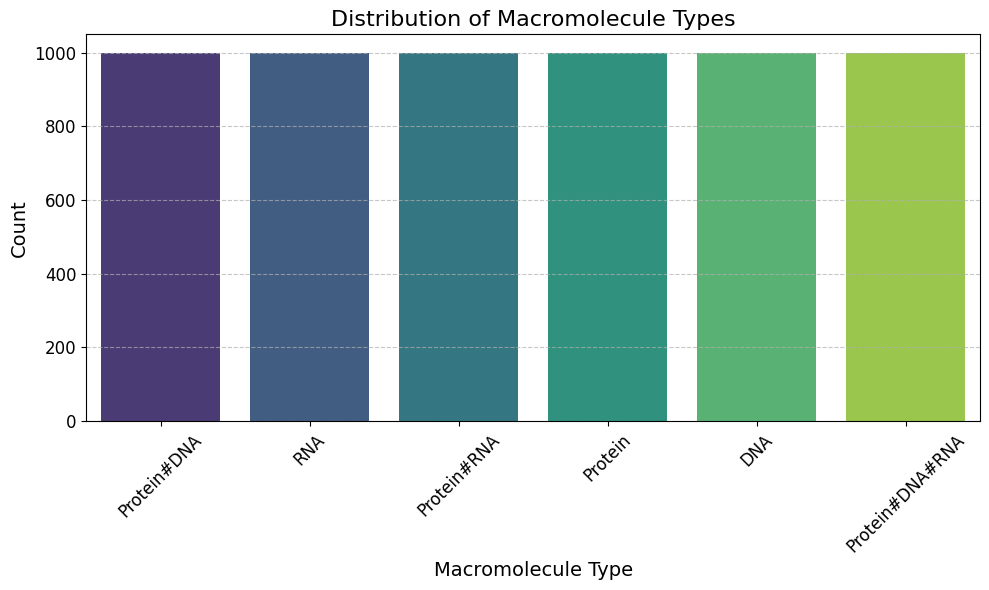

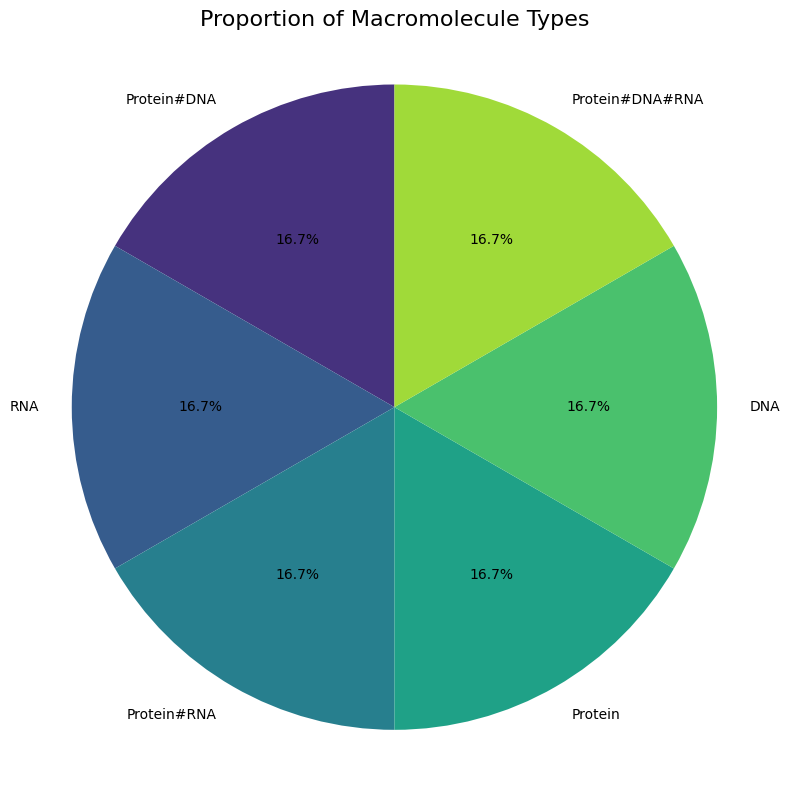

In [5]:

# Visualize the distribution of macromolecule types
type_counts = data['macromoleculeType'].value_counts()

# Bar plot for macromolecule type distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette="viridis")
plt.title('Distribution of Macromolecule Types', fontsize=16)
plt.xlabel('Macromolecule Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

# Pie chart for macromolecule type proportions
plt.figure(figsize=(8, 8))
plt.pie(
    type_counts, 
    labels=type_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("viridis", len(type_counts))
)
plt.title('Proportion of Macromolecule Types', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()


# Train Test Split

In [15]:
from sklearn.model_selection import train_test_split

X = data[['residueCount', 'sequence_length', 'chainId', 'structureId']]
y = data['macromoleculeType_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train["residueCount"])

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


4728   -0.336161
1332   -0.335206
3436   -0.298106
1575   -0.318157
1769   -0.334115
          ...   
779    -0.324226
5680   -0.050615
2082    0.874084
5356    0.041248
503    -0.299880
Name: residueCount, Length: 4800, dtype: float64
Shape of X_train: (4800, 4)
Shape of X_test: (1200, 4)
Shape of y_train: (4800,)
Shape of y_test: (1200,)


# Machine Learning

K-Means Clustering
Accuracy: 0.3225
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.39      0.40       200
           1       0.24      0.23      0.24       200
           2       0.23      0.22      0.23       200
           3       0.30      0.35      0.33       200
           4       0.42      0.47      0.45       200
           5       0.31      0.27      0.29       200

    accuracy                           0.32      1200
   macro avg       0.32      0.32      0.32      1200
weighted avg       0.32      0.32      0.32      1200



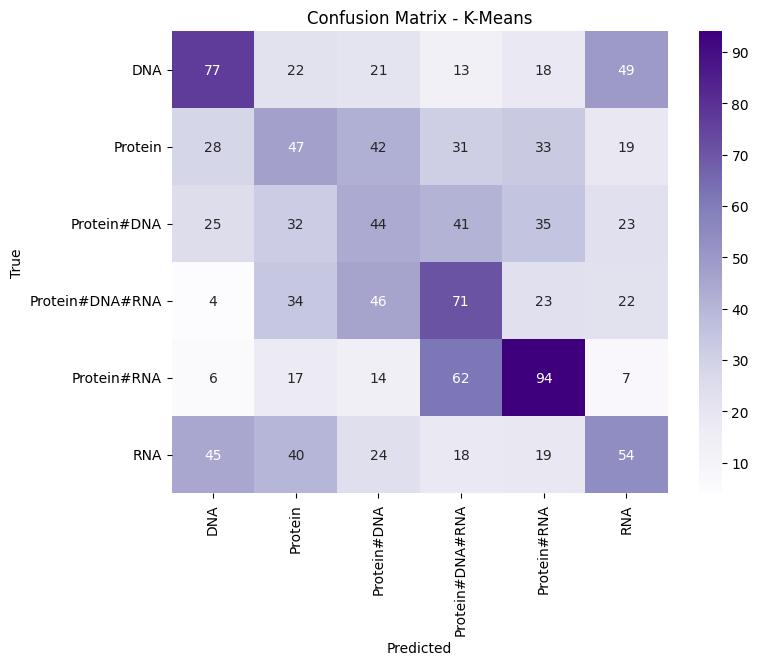

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import dump, load

# Apply K-Means clustering
kmeans = KMeans(n_clusters=len(encoder.classes_), random_state=42)
kmeans.fit(X_train)

# Predict using the K-Means model
y_pred_kmeans = kmeans.predict(X_test)

# Map clusters to actual labels
cluster_to_label = {}
for cluster in range(len(encoder.classes_)):
    true_labels = y_train[kmeans.labels_ == cluster]  # Get true labels for samples in each cluster
    if len(true_labels) > 0:
        cluster_to_label[cluster] = true_labels.mode()[0]  # Assign the most frequent label to the cluster

y_pred_kmeans = [cluster_to_label[cluster] for cluster in y_pred_kmeans]

# Display K-Means results
print("K-Means Clustering")
print("Accuracy:", accuracy_score(y_test, y_pred_kmeans))
print("Classification Report:\n", classification_report(y_test, y_pred_kmeans))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_kmeans), annot=True, fmt='d', cmap='Purples', 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - K-Means')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
with open('/content/drive/MyDrive/project/models/kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)
print("Model saved as kmeans_model.pkl")

Model saved as kmeans_model.pkl


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use

Logistic Regression
Accuracy: 0.20083333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.00      0.00      0.00       200
           2       0.14      0.05      0.07       200
           3       0.21      0.52      0.30       200
           4       0.20      0.64      0.31       200
           5       0.00      0.00      0.00       200

    accuracy                           0.20      1200
   macro avg       0.09      0.20      0.11      1200
weighted avg       0.09      0.20      0.11      1200



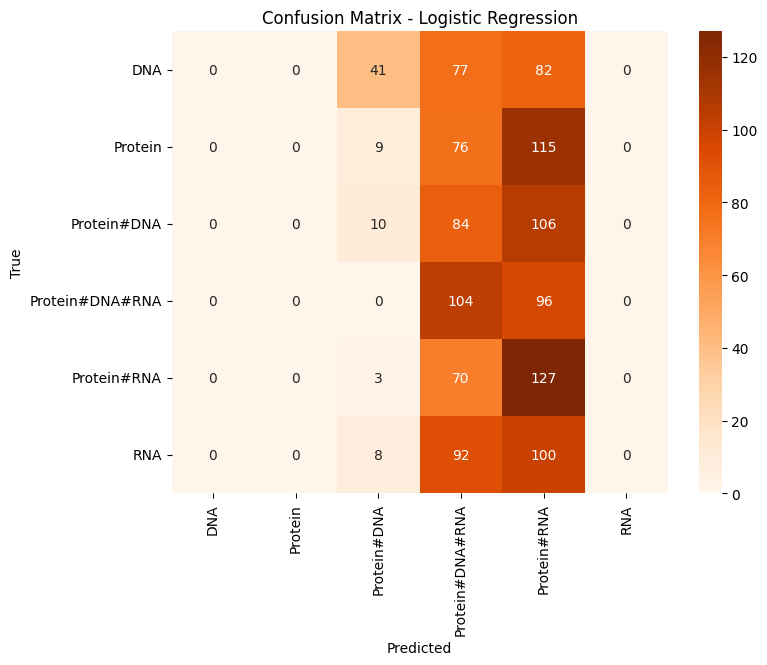

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train and evaluate a Logistic Regression model
logreg = LogisticRegression(
    max_iter=200,
    solver='saga',
    random_state=42
)
logreg.fit(X_train, y_train)

# Predict using the Logistic Regression model
y_pred_logreg = logreg.predict(X_test)

# Display Logistic Regression results
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_logreg), annot=True, fmt='d', cmap='Oranges', 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
with open('/content/drive/MyDrive/project/models/logreg_model.pkl', 'wb') as file:
    pickle.dump(logreg, file)
print("Model saved as logreg_model.pkl")

Model saved as logreg_model.pkl


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Random Forest Classifier
Accuracy: 0.7925
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.87       200
           1       0.62      0.69      0.66       200
           2       0.75      0.65      0.70       200
           3       0.83      0.92      0.87       200
           4       0.89      0.82      0.85       200
           5       0.83      0.77      0.80       200

    accuracy                           0.79      1200
   macro avg       0.80      0.79      0.79      1200
weighted avg       0.80      0.79      0.79      1200



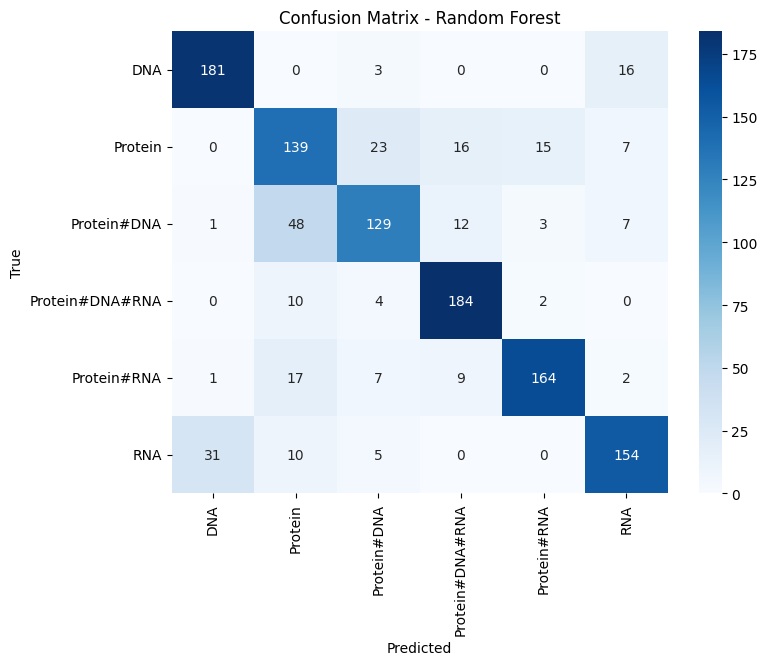

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=1)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Print classification metrics
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [ ]:
with open('/content/drive/MyDrive/project/models/randomforest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)
print("Model saved as randomforest_model.pkl")

Model saved as randomforest_model.pkl


# Deep Learning

**CNN**

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [18]:
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import pickle

# Scale the training and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit scaler to training data and transform
X_test_scaled = scaler.transform(X_test)  # Transform test data using the same scaler

# Save the scaler for later use
with open('std_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Convert scaled data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Print shapes for verification
print("X_train_tensor shape:", X_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader objects for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Shuffle for training
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # No shuffle for testing


      residueCount  sequence_length  chainId  structureId
4728     -0.336161        -0.492711       81          148
1332     -0.335206        -0.470307      122         2569
3436     -0.298106         0.089788      169          813
1575     -0.318157        -0.505513      295         2234
1769     -0.334115        -0.473507       81         2767
...            ...              ...      ...          ...
779      -0.324226        -0.502312      169         1954
5680     -0.050615        -0.502312      318         3240
2082      0.874084         0.064184       59         2009
5356      0.041248        -0.377491      289         4091
503      -0.299880        -0.143852      122         2116

[4800 rows x 4 columns]
[0.33801347 0.84928934 1.41589478 1.19824641]
(4800, 4)
torch.Size([4800, 4])


In [10]:
import torch
import torch.nn as nn

class BaseCNN(nn.Module):
    """
    A Convolutional Neural Network (CNN) for sequence classification.
    """
    def __init__(self, input_dim, num_classes, dropout_rate=0.5):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

        self.flatten_dim = self._get_flatten_dim(input_dim)  # Compute dimension after convolutions
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(p=dropout_rate)

    def _get_flatten_dim(self, input_dim):
        """
        Calculate the flattened dimension after convolutions and pooling.
        """
        x = torch.zeros(1, 1, input_dim)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        return x.numel()

    def forward(self, x):
        """
        Forward pass through the network.
        """
        x = x.unsqueeze(1)  # Add channel dimension for Conv1D
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)  # Output layer
        return x



In [11]:

input_dim = X_train_tensor.shape[1]
num_classes = len(y_train.unique())
print(input_dim)
print(num_classes)
model = BaseCNN(input_dim=input_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

4
6


In [ ]:

num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    for X_batch, y_batch in train_loader:
        # Move data to the correct device and perform forward/backward pass
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Print average loss for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 1.6505
Epoch 2/20, Loss: 1.4140
Epoch 3/20, Loss: 1.2810
Epoch 4/20, Loss: 1.1995
Epoch 5/20, Loss: 1.1589
Epoch 6/20, Loss: 1.1237
Epoch 7/20, Loss: 1.0964
Epoch 8/20, Loss: 1.0791
Epoch 9/20, Loss: 1.0491
Epoch 10/20, Loss: 1.0380
Epoch 11/20, Loss: 1.0218
Epoch 12/20, Loss: 1.0065
Epoch 13/20, Loss: 0.9904
Epoch 14/20, Loss: 0.9829
Epoch 15/20, Loss: 0.9712
Epoch 16/20, Loss: 0.9668
Epoch 17/20, Loss: 0.9626
Epoch 18/20, Loss: 0.9524
Epoch 19/20, Loss: 0.9539
Epoch 20/20, Loss: 0.9428


In [ ]:
# Set the model to evaluation mode
model.eval()
correct = 0
total = 0

# Disable gradient computation during evaluation
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()  # Count correct predictions

# Print the accuracy on the test set
print(f"Accuracy on test set: {100 * correct / total:.2f}%")


Accuracy on test set: 64.50%


In [11]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


In [12]:
class EarlyStopping:
    """
    Early stopping to terminate training when validation loss stops improving.
    """
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience  # Number of epochs to wait before stopping
        self.delta = delta  # Minimum change in loss to qualify as improvement
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        # Check if the validation loss has improved
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if improvement is detected
        else:
            self.counter += 1
            if self.counter >= self.patience:  # Stop if no improvement for `patience` epochs
                self.early_stop = True


In [ ]:
import optuna
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import torch

best_model_path = "/content/drive/MyDrive/project/models/best_CNN.pth"

global_best_accuracy = 0.0
global_best_model_state = None


def objective(trial):
    """
    Objective function for Optuna hyperparameter tuning.
    """
    global global_best_accuracy, global_best_model_state

    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
    num_epochs = 50 

    # 5-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        # Prepare data loaders for the current fold
        train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(Subset(train_dataset, val_idx), batch_size=batch_size, shuffle=False)

        # Initialize model, loss function, and optimizer
        model = BaseCNN(input_dim=input_dim, num_classes=num_classes, dropout_rate=dropout_rate).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Early stopping to prevent overfitting
        early_stopping = EarlyStopping(patience=7, delta=0.001)

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation phase
            model.eval()
            val_loss, correct, total = 0, 0, 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    val_loss += criterion(outputs, y_batch).item()
                    _, preds = torch.max(outputs, 1)
                    total += y_batch.size(0)
                    correct += (preds == y_batch).sum().item()

            val_loss /= len(val_loader)
            val_accuracy = correct / total

            print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, "
                  f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            # Check for early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        fold_accuracies.append(val_accuracy)

    mean_accuracy = np.mean(fold_accuracies)

    # Update the best model if the current one is better
    if mean_accuracy > global_best_accuracy:
        global_best_accuracy = mean_accuracy
        global_best_model_state = model.state_dict()

    return mean_accuracy


# Start the hyperparameter tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Save the best model state
if global_best_model_state is not None:
    torch.save(global_best_model_state, best_model_path)
    print(f"Best model saved to {best_model_path}")

# Print results
print("Best hyperparameters:")
print(study.best_trial.params)
print(f"Best Validation Accuracy: {global_best_accuracy:.4f}")


[I 2024-11-27 20:32:34,797] A new study created in memory with name: no-name-60f91d2a-1588-49c6-900b-ca3c09760f0a
<ipython-input-14-a3e57a575ea2>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-14-a3e57a575ea2>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)


Fold 1, Epoch 1, Train Loss: 1.5932, Validation Loss: 1.3717, Validation Accuracy: 0.4813
Fold 1, Epoch 2, Train Loss: 1.3418, Validation Loss: 1.1797, Validation Accuracy: 0.5198
Fold 1, Epoch 3, Train Loss: 1.1916, Validation Loss: 1.0629, Validation Accuracy: 0.5875
Fold 1, Epoch 4, Train Loss: 1.1213, Validation Loss: 1.0179, Validation Accuracy: 0.6188
Fold 1, Epoch 5, Train Loss: 1.0852, Validation Loss: 1.0287, Validation Accuracy: 0.6042
Fold 1, Epoch 6, Train Loss: 1.0588, Validation Loss: 0.9604, Validation Accuracy: 0.6198
Fold 1, Epoch 7, Train Loss: 1.0198, Validation Loss: 0.9504, Validation Accuracy: 0.6354
Fold 1, Epoch 8, Train Loss: 1.0093, Validation Loss: 0.9242, Validation Accuracy: 0.6646
Fold 1, Epoch 9, Train Loss: 0.9810, Validation Loss: 0.9376, Validation Accuracy: 0.6375
Fold 1, Epoch 10, Train Loss: 0.9979, Validation Loss: 0.8935, Validation Accuracy: 0.6542
Fold 1, Epoch 11, Train Loss: 0.9651, Validation Loss: 0.8779, Validation Accuracy: 0.6802
Fold 1, 

[I 2024-11-27 20:33:00,941] Trial 0 finished with value: 0.6712499999999999 and parameters: {'lr': 0.004204896252404516, 'batch_size': 128, 'dropout': 0.3512624379975189}. Best is trial 0 with value: 0.6712499999999999.


Fold 5, Epoch 28, Train Loss: 0.8499, Validation Loss: 0.8691, Validation Accuracy: 0.6729
Early stopping triggered at epoch 28
Fold 1, Epoch 1, Train Loss: 1.7933, Validation Loss: 1.7863, Validation Accuracy: 0.1802
Fold 1, Epoch 2, Train Loss: 1.7850, Validation Loss: 1.7784, Validation Accuracy: 0.2167
Fold 1, Epoch 3, Train Loss: 1.7772, Validation Loss: 1.7699, Validation Accuracy: 0.2677
Fold 1, Epoch 4, Train Loss: 1.7673, Validation Loss: 1.7607, Validation Accuracy: 0.2865
Fold 1, Epoch 5, Train Loss: 1.7567, Validation Loss: 1.7502, Validation Accuracy: 0.3667
Fold 1, Epoch 6, Train Loss: 1.7463, Validation Loss: 1.7385, Validation Accuracy: 0.3729
Fold 1, Epoch 7, Train Loss: 1.7341, Validation Loss: 1.7255, Validation Accuracy: 0.3552
Fold 1, Epoch 8, Train Loss: 1.7205, Validation Loss: 1.7111, Validation Accuracy: 0.3500
Fold 1, Epoch 9, Train Loss: 1.7062, Validation Loss: 1.6958, Validation Accuracy: 0.3479
Fold 1, Epoch 10, Train Loss: 1.6922, Validation Loss: 1.6795,

[I 2024-11-27 20:33:30,091] Trial 1 finished with value: 0.51875 and parameters: {'lr': 6.550943858390327e-05, 'batch_size': 128, 'dropout': 0.13683257774738672}. Best is trial 0 with value: 0.6712499999999999.


Fold 5, Epoch 50, Train Loss: 1.2882, Validation Loss: 1.2318, Validation Accuracy: 0.5312
Fold 1, Epoch 1, Train Loss: 1.7763, Validation Loss: 1.7499, Validation Accuracy: 0.3042
Fold 1, Epoch 2, Train Loss: 1.7217, Validation Loss: 1.6691, Validation Accuracy: 0.3688
Fold 1, Epoch 3, Train Loss: 1.6187, Validation Loss: 1.5498, Validation Accuracy: 0.4021
Fold 1, Epoch 4, Train Loss: 1.5257, Validation Loss: 1.4662, Validation Accuracy: 0.4490
Fold 1, Epoch 5, Train Loss: 1.4730, Validation Loss: 1.4229, Validation Accuracy: 0.4729
Fold 1, Epoch 6, Train Loss: 1.4364, Validation Loss: 1.3833, Validation Accuracy: 0.4844
Fold 1, Epoch 7, Train Loss: 1.4087, Validation Loss: 1.3465, Validation Accuracy: 0.5125
Fold 1, Epoch 8, Train Loss: 1.3769, Validation Loss: 1.3121, Validation Accuracy: 0.5198
Fold 1, Epoch 9, Train Loss: 1.3507, Validation Loss: 1.2753, Validation Accuracy: 0.5312
Fold 1, Epoch 10, Train Loss: 1.3188, Validation Loss: 1.2397, Validation Accuracy: 0.5510
Fold 1, 

[I 2024-11-27 20:34:00,250] Trial 2 finished with value: 0.6183333333333333 and parameters: {'lr': 0.0004275009485892232, 'batch_size': 128, 'dropout': 0.38942083010914696}. Best is trial 0 with value: 0.6712499999999999.


Fold 5, Epoch 49, Train Loss: 0.9903, Validation Loss: 0.9450, Validation Accuracy: 0.6365
Fold 5, Epoch 50, Train Loss: 0.9874, Validation Loss: 0.9332, Validation Accuracy: 0.6354
Fold 1, Epoch 1, Train Loss: 1.7798, Validation Loss: 1.7561, Validation Accuracy: 0.2750
Fold 1, Epoch 2, Train Loss: 1.7232, Validation Loss: 1.6806, Validation Accuracy: 0.3448
Fold 1, Epoch 3, Train Loss: 1.6357, Validation Loss: 1.5776, Validation Accuracy: 0.4010
Fold 1, Epoch 4, Train Loss: 1.5465, Validation Loss: 1.4819, Validation Accuracy: 0.4208
Fold 1, Epoch 5, Train Loss: 1.4691, Validation Loss: 1.4067, Validation Accuracy: 0.5000
Fold 1, Epoch 6, Train Loss: 1.4099, Validation Loss: 1.3487, Validation Accuracy: 0.5229
Fold 1, Epoch 7, Train Loss: 1.3665, Validation Loss: 1.2987, Validation Accuracy: 0.5385
Fold 1, Epoch 8, Train Loss: 1.3262, Validation Loss: 1.2562, Validation Accuracy: 0.5490
Fold 1, Epoch 9, Train Loss: 1.2900, Validation Loss: 1.2194, Validation Accuracy: 0.5708
Fold 1, 

[I 2024-11-27 20:34:49,227] Trial 3 finished with value: 0.6264583333333335 and parameters: {'lr': 0.0002394168846369851, 'batch_size': 64, 'dropout': 0.40082142836147494}. Best is trial 0 with value: 0.6712499999999999.


Fold 5, Epoch 49, Train Loss: 0.9824, Validation Loss: 0.9489, Validation Accuracy: 0.6260
Fold 5, Epoch 50, Train Loss: 0.9806, Validation Loss: 0.9446, Validation Accuracy: 0.6531
Fold 1, Epoch 1, Train Loss: 1.6134, Validation Loss: 1.4011, Validation Accuracy: 0.4292
Fold 1, Epoch 2, Train Loss: 1.3566, Validation Loss: 1.2353, Validation Accuracy: 0.5479
Fold 1, Epoch 3, Train Loss: 1.2471, Validation Loss: 1.1382, Validation Accuracy: 0.5708
Fold 1, Epoch 4, Train Loss: 1.1895, Validation Loss: 1.0956, Validation Accuracy: 0.5760
Fold 1, Epoch 5, Train Loss: 1.1564, Validation Loss: 1.0626, Validation Accuracy: 0.5833
Fold 1, Epoch 6, Train Loss: 1.1087, Validation Loss: 1.0348, Validation Accuracy: 0.6062
Fold 1, Epoch 7, Train Loss: 1.0878, Validation Loss: 1.0176, Validation Accuracy: 0.6104
Fold 1, Epoch 8, Train Loss: 1.0620, Validation Loss: 0.9972, Validation Accuracy: 0.6094
Fold 1, Epoch 9, Train Loss: 1.0455, Validation Loss: 0.9877, Validation Accuracy: 0.6354
Fold 1, 

[I 2024-11-27 20:35:29,658] Trial 4 finished with value: 0.6872916666666666 and parameters: {'lr': 0.0012641045591818582, 'batch_size': 64, 'dropout': 0.20640559984401047}. Best is trial 4 with value: 0.6872916666666666.


Fold 5, Epoch 49, Train Loss: 0.8110, Validation Loss: 0.8207, Validation Accuracy: 0.6937
Fold 5, Epoch 50, Train Loss: 0.8084, Validation Loss: 0.8009, Validation Accuracy: 0.7219
Fold 1, Epoch 1, Train Loss: 1.7935, Validation Loss: 1.7919, Validation Accuracy: 0.1615
Fold 1, Epoch 2, Train Loss: 1.7866, Validation Loss: 1.7848, Validation Accuracy: 0.1729
Fold 1, Epoch 3, Train Loss: 1.7799, Validation Loss: 1.7777, Validation Accuracy: 0.1844
Fold 1, Epoch 4, Train Loss: 1.7719, Validation Loss: 1.7697, Validation Accuracy: 0.1885
Fold 1, Epoch 5, Train Loss: 1.7637, Validation Loss: 1.7607, Validation Accuracy: 0.2031
Fold 1, Epoch 6, Train Loss: 1.7533, Validation Loss: 1.7501, Validation Accuracy: 0.2573
Fold 1, Epoch 7, Train Loss: 1.7426, Validation Loss: 1.7377, Validation Accuracy: 0.2948
Fold 1, Epoch 8, Train Loss: 1.7301, Validation Loss: 1.7242, Validation Accuracy: 0.3365
Fold 1, Epoch 9, Train Loss: 1.7164, Validation Loss: 1.7090, Validation Accuracy: 0.3479
Fold 1, 

[I 2024-11-27 20:36:56,684] Trial 5 finished with value: 0.5064583333333333 and parameters: {'lr': 2.3735213682762747e-05, 'batch_size': 32, 'dropout': 0.11467642735719714}. Best is trial 4 with value: 0.6872916666666666.


Fold 5, Epoch 50, Train Loss: 1.3014, Validation Loss: 1.2654, Validation Accuracy: 0.5104
Fold 1, Epoch 1, Train Loss: 1.7987, Validation Loss: 1.7964, Validation Accuracy: 0.1625
Fold 1, Epoch 2, Train Loss: 1.7967, Validation Loss: 1.7941, Validation Accuracy: 0.1615
Fold 1, Epoch 3, Train Loss: 1.7930, Validation Loss: 1.7920, Validation Accuracy: 0.1615
Fold 1, Epoch 4, Train Loss: 1.7919, Validation Loss: 1.7899, Validation Accuracy: 0.1615
Fold 1, Epoch 5, Train Loss: 1.7891, Validation Loss: 1.7878, Validation Accuracy: 0.1615
Fold 1, Epoch 6, Train Loss: 1.7875, Validation Loss: 1.7857, Validation Accuracy: 0.1615
Fold 1, Epoch 7, Train Loss: 1.7846, Validation Loss: 1.7837, Validation Accuracy: 0.1615
Fold 1, Epoch 8, Train Loss: 1.7820, Validation Loss: 1.7814, Validation Accuracy: 0.1615
Fold 1, Epoch 9, Train Loss: 1.7803, Validation Loss: 1.7792, Validation Accuracy: 0.1615
Fold 1, Epoch 10, Train Loss: 1.7772, Validation Loss: 1.7769, Validation Accuracy: 0.1615
Fold 1, 

[I 2024-11-27 20:37:27,215] Trial 6 finished with value: 0.399375 and parameters: {'lr': 1.9817627385787114e-05, 'batch_size': 128, 'dropout': 0.27206523411329553}. Best is trial 4 with value: 0.6872916666666666.


Fold 5, Epoch 49, Train Loss: 1.5815, Validation Loss: 1.5592, Validation Accuracy: 0.4417
Fold 5, Epoch 50, Train Loss: 1.5775, Validation Loss: 1.5532, Validation Accuracy: 0.4406
Fold 1, Epoch 1, Train Loss: 1.7798, Validation Loss: 1.7777, Validation Accuracy: 0.2698
Fold 1, Epoch 2, Train Loss: 1.7777, Validation Loss: 1.7754, Validation Accuracy: 0.2708
Fold 1, Epoch 3, Train Loss: 1.7752, Validation Loss: 1.7729, Validation Accuracy: 0.2740
Fold 1, Epoch 4, Train Loss: 1.7744, Validation Loss: 1.7705, Validation Accuracy: 0.2729
Fold 1, Epoch 5, Train Loss: 1.7723, Validation Loss: 1.7681, Validation Accuracy: 0.2750
Fold 1, Epoch 6, Train Loss: 1.7708, Validation Loss: 1.7656, Validation Accuracy: 0.2823
Fold 1, Epoch 7, Train Loss: 1.7645, Validation Loss: 1.7629, Validation Accuracy: 0.2865
Fold 1, Epoch 8, Train Loss: 1.7639, Validation Loss: 1.7603, Validation Accuracy: 0.2885
Fold 1, Epoch 9, Train Loss: 1.7612, Validation Loss: 1.7575, Validation Accuracy: 0.2917
Fold 1, 

[I 2024-11-27 20:37:56,735] Trial 7 finished with value: 0.41624999999999995 and parameters: {'lr': 2.423345480210757e-05, 'batch_size': 128, 'dropout': 0.39216106447090027}. Best is trial 4 with value: 0.6872916666666666.


Fold 5, Epoch 49, Train Loss: 1.5793, Validation Loss: 1.5587, Validation Accuracy: 0.4229
Fold 5, Epoch 50, Train Loss: 1.5743, Validation Loss: 1.5526, Validation Accuracy: 0.4313
Fold 1, Epoch 1, Train Loss: 1.7616, Validation Loss: 1.7268, Validation Accuracy: 0.2823
Fold 1, Epoch 2, Train Loss: 1.6736, Validation Loss: 1.6121, Validation Accuracy: 0.4010
Fold 1, Epoch 3, Train Loss: 1.5587, Validation Loss: 1.5024, Validation Accuracy: 0.4333
Fold 1, Epoch 4, Train Loss: 1.4737, Validation Loss: 1.4326, Validation Accuracy: 0.4677
Fold 1, Epoch 5, Train Loss: 1.4209, Validation Loss: 1.3819, Validation Accuracy: 0.4948
Fold 1, Epoch 6, Train Loss: 1.3769, Validation Loss: 1.3326, Validation Accuracy: 0.5188
Fold 1, Epoch 7, Train Loss: 1.3334, Validation Loss: 1.2805, Validation Accuracy: 0.5292
Fold 1, Epoch 8, Train Loss: 1.2914, Validation Loss: 1.2370, Validation Accuracy: 0.5396
Fold 1, Epoch 9, Train Loss: 1.2557, Validation Loss: 1.2029, Validation Accuracy: 0.5406
Fold 1, 

[I 2024-11-27 20:38:44,726] Trial 8 finished with value: 0.6387499999999999 and parameters: {'lr': 0.000283389617554391, 'batch_size': 64, 'dropout': 0.12223416821214941}. Best is trial 4 with value: 0.6872916666666666.


Fold 5, Epoch 50, Train Loss: 0.9311, Validation Loss: 0.9054, Validation Accuracy: 0.6594
Fold 1, Epoch 1, Train Loss: 1.7919, Validation Loss: 1.7863, Validation Accuracy: 0.2656
Fold 1, Epoch 2, Train Loss: 1.7812, Validation Loss: 1.7741, Validation Accuracy: 0.2948
Fold 1, Epoch 3, Train Loss: 1.7674, Validation Loss: 1.7598, Validation Accuracy: 0.2958
Fold 1, Epoch 4, Train Loss: 1.7525, Validation Loss: 1.7414, Validation Accuracy: 0.3000
Fold 1, Epoch 5, Train Loss: 1.7311, Validation Loss: 1.7172, Validation Accuracy: 0.3073
Fold 1, Epoch 6, Train Loss: 1.7047, Validation Loss: 1.6865, Validation Accuracy: 0.3208
Fold 1, Epoch 7, Train Loss: 1.6750, Validation Loss: 1.6515, Validation Accuracy: 0.3458
Fold 1, Epoch 8, Train Loss: 1.6394, Validation Loss: 1.6142, Validation Accuracy: 0.3531
Fold 1, Epoch 9, Train Loss: 1.6056, Validation Loss: 1.5784, Validation Accuracy: 0.3781
Fold 1, Epoch 10, Train Loss: 1.5729, Validation Loss: 1.5462, Validation Accuracy: 0.4000
Fold 1, 

[I 2024-11-27 20:39:33,436] Trial 9 finished with value: 0.5631250000000001 and parameters: {'lr': 7.212291973297126e-05, 'batch_size': 64, 'dropout': 0.28338300004631145}. Best is trial 4 with value: 0.6872916666666666.


Fold 5, Epoch 49, Train Loss: 1.2443, Validation Loss: 1.1870, Validation Accuracy: 0.5469
Fold 5, Epoch 50, Train Loss: 1.2387, Validation Loss: 1.1854, Validation Accuracy: 0.5531
Fold 1, Epoch 1, Train Loss: 1.3592, Validation Loss: 1.0810, Validation Accuracy: 0.5437
Fold 1, Epoch 2, Train Loss: 1.0895, Validation Loss: 1.0075, Validation Accuracy: 0.6177
Fold 1, Epoch 3, Train Loss: 1.0553, Validation Loss: 1.0199, Validation Accuracy: 0.6135
Fold 1, Epoch 4, Train Loss: 1.0133, Validation Loss: 0.9120, Validation Accuracy: 0.6583
Fold 1, Epoch 5, Train Loss: 1.0117, Validation Loss: 0.9226, Validation Accuracy: 0.6521
Fold 1, Epoch 6, Train Loss: 0.9631, Validation Loss: 0.9471, Validation Accuracy: 0.6562
Fold 1, Epoch 7, Train Loss: 0.9538, Validation Loss: 0.9455, Validation Accuracy: 0.6375
Fold 1, Epoch 8, Train Loss: 0.9574, Validation Loss: 0.9118, Validation Accuracy: 0.6521
Fold 1, Epoch 9, Train Loss: 0.9535, Validation Loss: 0.8811, Validation Accuracy: 0.6729
Fold 1, 

[I 2024-11-27 20:40:24,161] Trial 10 finished with value: 0.6647916666666667 and parameters: {'lr': 0.007583443302962046, 'batch_size': 32, 'dropout': 0.22196337568898952}. Best is trial 4 with value: 0.6872916666666666.


Fold 5, Epoch 33, Train Loss: 0.7839, Validation Loss: 0.8631, Validation Accuracy: 0.6813
Early stopping triggered at epoch 33
Fold 1, Epoch 1, Train Loss: 1.4820, Validation Loss: 1.2353, Validation Accuracy: 0.5208
Fold 1, Epoch 2, Train Loss: 1.2393, Validation Loss: 1.0674, Validation Accuracy: 0.6062
Fold 1, Epoch 3, Train Loss: 1.1107, Validation Loss: 1.0319, Validation Accuracy: 0.5917
Fold 1, Epoch 4, Train Loss: 1.0876, Validation Loss: 0.9758, Validation Accuracy: 0.6229
Fold 1, Epoch 5, Train Loss: 1.0658, Validation Loss: 0.9679, Validation Accuracy: 0.6250
Fold 1, Epoch 6, Train Loss: 1.0321, Validation Loss: 0.9286, Validation Accuracy: 0.6479
Fold 1, Epoch 7, Train Loss: 1.0039, Validation Loss: 0.8970, Validation Accuracy: 0.6615
Fold 1, Epoch 8, Train Loss: 1.0049, Validation Loss: 0.9429, Validation Accuracy: 0.6354
Fold 1, Epoch 9, Train Loss: 0.9612, Validation Loss: 0.8991, Validation Accuracy: 0.6594
Fold 1, Epoch 10, Train Loss: 0.9613, Validation Loss: 0.8835,

[I 2024-11-27 20:40:57,788] Trial 11 finished with value: 0.6777083333333332 and parameters: {'lr': 0.004586510774676211, 'batch_size': 64, 'dropout': 0.48747007154475985}. Best is trial 4 with value: 0.6872916666666666.


Fold 5, Epoch 50, Train Loss: 0.8013, Validation Loss: 0.8140, Validation Accuracy: 0.7188
Early stopping triggered at epoch 50
Fold 1, Epoch 1, Train Loss: 1.6464, Validation Loss: 1.4160, Validation Accuracy: 0.4740
Fold 1, Epoch 2, Train Loss: 1.3784, Validation Loss: 1.2486, Validation Accuracy: 0.5260
Fold 1, Epoch 3, Train Loss: 1.2518, Validation Loss: 1.1288, Validation Accuracy: 0.5802
Fold 1, Epoch 4, Train Loss: 1.1812, Validation Loss: 1.0904, Validation Accuracy: 0.5854
Fold 1, Epoch 5, Train Loss: 1.1273, Validation Loss: 1.0495, Validation Accuracy: 0.5844
Fold 1, Epoch 6, Train Loss: 1.0936, Validation Loss: 1.0162, Validation Accuracy: 0.6240
Fold 1, Epoch 7, Train Loss: 1.0741, Validation Loss: 1.0078, Validation Accuracy: 0.6219
Fold 1, Epoch 8, Train Loss: 1.0503, Validation Loss: 0.9991, Validation Accuracy: 0.6010
Fold 1, Epoch 9, Train Loss: 1.0334, Validation Loss: 0.9784, Validation Accuracy: 0.6438
Fold 1, Epoch 10, Train Loss: 1.0208, Validation Loss: 0.9659,

[I 2024-11-27 20:41:46,419] Trial 12 finished with value: 0.6908333333333333 and parameters: {'lr': 0.002103302875554297, 'batch_size': 64, 'dropout': 0.4531421454079495}. Best is trial 12 with value: 0.6908333333333333.


Fold 5, Epoch 50, Train Loss: 0.7737, Validation Loss: 0.7694, Validation Accuracy: 0.7177
Fold 1, Epoch 1, Train Loss: 1.5817, Validation Loss: 1.3911, Validation Accuracy: 0.3885
Fold 1, Epoch 2, Train Loss: 1.3419, Validation Loss: 1.2194, Validation Accuracy: 0.5156
Fold 1, Epoch 3, Train Loss: 1.2379, Validation Loss: 1.1677, Validation Accuracy: 0.5375
Fold 1, Epoch 4, Train Loss: 1.1815, Validation Loss: 1.1059, Validation Accuracy: 0.5719
Fold 1, Epoch 5, Train Loss: 1.1330, Validation Loss: 1.0646, Validation Accuracy: 0.5771
Fold 1, Epoch 6, Train Loss: 1.1035, Validation Loss: 1.0373, Validation Accuracy: 0.6021
Fold 1, Epoch 7, Train Loss: 1.0839, Validation Loss: 1.0486, Validation Accuracy: 0.5802
Fold 1, Epoch 8, Train Loss: 1.0543, Validation Loss: 1.0213, Validation Accuracy: 0.6062
Fold 1, Epoch 9, Train Loss: 1.0472, Validation Loss: 0.9922, Validation Accuracy: 0.6146
Fold 1, Epoch 10, Train Loss: 1.0280, Validation Loss: 0.9691, Validation Accuracy: 0.6344
Fold 1, 

[I 2024-11-27 20:42:34,246] Trial 13 finished with value: 0.689375 and parameters: {'lr': 0.0014561448887687497, 'batch_size': 64, 'dropout': 0.2017612750214518}. Best is trial 12 with value: 0.6908333333333333.


Fold 5, Epoch 49, Train Loss: 0.7924, Validation Loss: 0.7937, Validation Accuracy: 0.7208
Fold 5, Epoch 50, Train Loss: 0.7803, Validation Loss: 0.7896, Validation Accuracy: 0.7208
Fold 1, Epoch 1, Train Loss: 1.6526, Validation Loss: 1.4214, Validation Accuracy: 0.4302
Fold 1, Epoch 2, Train Loss: 1.3895, Validation Loss: 1.2355, Validation Accuracy: 0.5333
Fold 1, Epoch 3, Train Loss: 1.2725, Validation Loss: 1.1411, Validation Accuracy: 0.5635
Fold 1, Epoch 4, Train Loss: 1.2051, Validation Loss: 1.0936, Validation Accuracy: 0.5802
Fold 1, Epoch 5, Train Loss: 1.1665, Validation Loss: 1.0540, Validation Accuracy: 0.6021
Fold 1, Epoch 6, Train Loss: 1.1113, Validation Loss: 1.0226, Validation Accuracy: 0.5990
Fold 1, Epoch 7, Train Loss: 1.0855, Validation Loss: 1.0116, Validation Accuracy: 0.6073
Fold 1, Epoch 8, Train Loss: 1.0612, Validation Loss: 1.0046, Validation Accuracy: 0.6240
Fold 1, Epoch 9, Train Loss: 1.0481, Validation Loss: 0.9540, Validation Accuracy: 0.6354
Fold 1, 

[I 2024-11-27 20:43:23,588] Trial 14 finished with value: 0.6912499999999999 and parameters: {'lr': 0.0014357440119805132, 'batch_size': 64, 'dropout': 0.49499598498895664}. Best is trial 14 with value: 0.6912499999999999.


Fold 5, Epoch 50, Train Loss: 0.8213, Validation Loss: 0.7890, Validation Accuracy: 0.7156
Fold 1, Epoch 1, Train Loss: 1.6460, Validation Loss: 1.4517, Validation Accuracy: 0.4292
Fold 1, Epoch 2, Train Loss: 1.4009, Validation Loss: 1.2479, Validation Accuracy: 0.5396
Fold 1, Epoch 3, Train Loss: 1.2862, Validation Loss: 1.1710, Validation Accuracy: 0.5719
Fold 1, Epoch 4, Train Loss: 1.2244, Validation Loss: 1.1259, Validation Accuracy: 0.5687
Fold 1, Epoch 5, Train Loss: 1.1721, Validation Loss: 1.0907, Validation Accuracy: 0.5844
Fold 1, Epoch 6, Train Loss: 1.1557, Validation Loss: 1.0643, Validation Accuracy: 0.6094
Fold 1, Epoch 7, Train Loss: 1.1224, Validation Loss: 1.0545, Validation Accuracy: 0.6031
Fold 1, Epoch 8, Train Loss: 1.0971, Validation Loss: 1.0196, Validation Accuracy: 0.6156
Fold 1, Epoch 9, Train Loss: 1.0802, Validation Loss: 1.0053, Validation Accuracy: 0.6219
Fold 1, Epoch 10, Train Loss: 1.0662, Validation Loss: 1.0036, Validation Accuracy: 0.6094
Fold 1, 

[I 2024-11-27 20:44:11,888] Trial 15 finished with value: 0.6791666666666667 and parameters: {'lr': 0.0014550964638785897, 'batch_size': 64, 'dropout': 0.48166231189730513}. Best is trial 14 with value: 0.6912499999999999.


Fold 5, Epoch 50, Train Loss: 0.8630, Validation Loss: 0.8125, Validation Accuracy: 0.7031
Fold 1, Epoch 1, Train Loss: 1.7207, Validation Loss: 1.5963, Validation Accuracy: 0.4062
Fold 1, Epoch 2, Train Loss: 1.5181, Validation Loss: 1.4234, Validation Accuracy: 0.4344
Fold 1, Epoch 3, Train Loss: 1.4195, Validation Loss: 1.3352, Validation Accuracy: 0.5188
Fold 1, Epoch 4, Train Loss: 1.3466, Validation Loss: 1.2379, Validation Accuracy: 0.5469
Fold 1, Epoch 5, Train Loss: 1.2609, Validation Loss: 1.1736, Validation Accuracy: 0.5729
Fold 1, Epoch 6, Train Loss: 1.2268, Validation Loss: 1.1347, Validation Accuracy: 0.5854
Fold 1, Epoch 7, Train Loss: 1.1859, Validation Loss: 1.0965, Validation Accuracy: 0.5938
Fold 1, Epoch 8, Train Loss: 1.1537, Validation Loss: 1.0677, Validation Accuracy: 0.6010
Fold 1, Epoch 9, Train Loss: 1.1355, Validation Loss: 1.0566, Validation Accuracy: 0.6083
Fold 1, Epoch 10, Train Loss: 1.1173, Validation Loss: 1.0389, Validation Accuracy: 0.6188
Fold 1, 

[I 2024-11-27 20:45:02,532] Trial 16 finished with value: 0.6722916666666666 and parameters: {'lr': 0.0007303251352282901, 'batch_size': 64, 'dropout': 0.4446733320752093}. Best is trial 14 with value: 0.6912499999999999.


Fold 5, Epoch 50, Train Loss: 0.9020, Validation Loss: 0.8619, Validation Accuracy: 0.6854
Fold 1, Epoch 1, Train Loss: 1.4717, Validation Loss: 1.1929, Validation Accuracy: 0.5563
Fold 1, Epoch 2, Train Loss: 1.1963, Validation Loss: 1.0633, Validation Accuracy: 0.5948
Fold 1, Epoch 3, Train Loss: 1.1140, Validation Loss: 1.0215, Validation Accuracy: 0.6177
Fold 1, Epoch 4, Train Loss: 1.0873, Validation Loss: 0.9929, Validation Accuracy: 0.6375
Fold 1, Epoch 5, Train Loss: 1.0499, Validation Loss: 0.9484, Validation Accuracy: 0.6417
Fold 1, Epoch 6, Train Loss: 1.0359, Validation Loss: 0.9556, Validation Accuracy: 0.6323
Fold 1, Epoch 7, Train Loss: 1.0132, Validation Loss: 0.9308, Validation Accuracy: 0.6354
Fold 1, Epoch 8, Train Loss: 0.9991, Validation Loss: 0.9291, Validation Accuracy: 0.6635
Fold 1, Epoch 9, Train Loss: 0.9709, Validation Loss: 0.9373, Validation Accuracy: 0.6521
Fold 1, Epoch 10, Train Loss: 0.9621, Validation Loss: 0.8842, Validation Accuracy: 0.6656
Fold 1, 

[I 2024-11-27 20:46:15,561] Trial 17 finished with value: 0.69625 and parameters: {'lr': 0.002424061615527461, 'batch_size': 32, 'dropout': 0.44880576671981864}. Best is trial 17 with value: 0.69625.


Fold 5, Epoch 50, Train Loss: 0.7797, Validation Loss: 0.8031, Validation Accuracy: 0.7188
Fold 1, Epoch 1, Train Loss: 1.4225, Validation Loss: 1.1628, Validation Accuracy: 0.5719
Fold 1, Epoch 2, Train Loss: 1.1516, Validation Loss: 1.0415, Validation Accuracy: 0.6010
Fold 1, Epoch 3, Train Loss: 1.0741, Validation Loss: 0.9743, Validation Accuracy: 0.6292
Fold 1, Epoch 4, Train Loss: 1.0378, Validation Loss: 0.9644, Validation Accuracy: 0.6406
Fold 1, Epoch 5, Train Loss: 1.0090, Validation Loss: 0.9297, Validation Accuracy: 0.6552
Fold 1, Epoch 6, Train Loss: 0.9888, Validation Loss: 0.9248, Validation Accuracy: 0.6344
Fold 1, Epoch 7, Train Loss: 0.9544, Validation Loss: 0.9194, Validation Accuracy: 0.6271
Fold 1, Epoch 8, Train Loss: 0.9562, Validation Loss: 0.9086, Validation Accuracy: 0.6396
Fold 1, Epoch 9, Train Loss: 0.9364, Validation Loss: 0.8989, Validation Accuracy: 0.6469
Fold 1, Epoch 10, Train Loss: 0.9186, Validation Loss: 0.8794, Validation Accuracy: 0.6604
Fold 1, 

[I 2024-11-27 20:47:23,607] Trial 18 finished with value: 0.6979166666666667 and parameters: {'lr': 0.003472145213733102, 'batch_size': 32, 'dropout': 0.3245461493381439}. Best is trial 18 with value: 0.6979166666666667.


Fold 5, Epoch 33, Train Loss: 0.8032, Validation Loss: 0.8242, Validation Accuracy: 0.6958
Early stopping triggered at epoch 33
Fold 1, Epoch 1, Train Loss: 1.4598, Validation Loss: 1.1919, Validation Accuracy: 0.5073
Fold 1, Epoch 2, Train Loss: 1.1807, Validation Loss: 1.0660, Validation Accuracy: 0.5896
Fold 1, Epoch 3, Train Loss: 1.1010, Validation Loss: 1.0355, Validation Accuracy: 0.6000
Fold 1, Epoch 4, Train Loss: 1.0590, Validation Loss: 1.0718, Validation Accuracy: 0.5677
Fold 1, Epoch 5, Train Loss: 1.0410, Validation Loss: 0.9807, Validation Accuracy: 0.6229
Fold 1, Epoch 6, Train Loss: 1.0296, Validation Loss: 0.9708, Validation Accuracy: 0.6281
Fold 1, Epoch 7, Train Loss: 0.9984, Validation Loss: 0.9544, Validation Accuracy: 0.6573
Fold 1, Epoch 8, Train Loss: 0.9752, Validation Loss: 0.9364, Validation Accuracy: 0.6458
Fold 1, Epoch 9, Train Loss: 0.9717, Validation Loss: 0.9058, Validation Accuracy: 0.6552
Fold 1, Epoch 10, Train Loss: 0.9387, Validation Loss: 0.8837,

[I 2024-11-27 20:48:24,680] Trial 19 finished with value: 0.6806249999999999 and parameters: {'lr': 0.0037616312539259364, 'batch_size': 32, 'dropout': 0.31902899005924035}. Best is trial 18 with value: 0.6979166666666667.


Fold 5, Epoch 27, Train Loss: 0.8206, Validation Loss: 0.8808, Validation Accuracy: 0.6813
Early stopping triggered at epoch 27
Best model saved to /content/drive/MyDrive/project/models/best_CNN.pth
Best hyperparameters:
{'lr': 0.003472145213733102, 'batch_size': 32, 'dropout': 0.3245461493381439}
Best Validation Accuracy: 0.6979


**RNN**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader
import numpy as np

# Path to save the best RNN model
best_model_path_rnn = "/content/drive/MyDrive/project/models/best_rnn_model.pth"

global_best_accuracy_rnn = 0.0
global_best_model_state_rnn = None

# Define the RNN classifier
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add a sequence dimension if needed
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last time step for classification
        return out

# Objective function for Optuna hyperparameter tuning
def objective_rnn(trial):
    global global_best_accuracy_rnn, global_best_model_state_rnn

    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    hidden_dim = trial.suggest_int('hidden_dim', 32, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_epochs = 50

    k_folds = 5
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []

    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(Subset(train_dataset, val_idx), batch_size=batch_size, shuffle=False)

        model = RNNClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, num_layers=num_layers).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        early_stopping = EarlyStopping(patience=7, delta=0.001)

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.unsqueeze(1).to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation loop
            model.eval()
            val_loss, correct, total = 0, 0, 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.unsqueeze(1).to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    val_loss += criterion(outputs, y_batch).item()
                    _, preds = torch.max(outputs, 1)
                    total += y_batch.size(0)
                    correct += (preds == y_batch).sum().item()

            val_loss /= len(val_loader)
            val_accuracy = correct / total

            print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, "
                  f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            if early_stopping(val_loss):  # Early stopping check
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        fold_accuracies.append(val_accuracy)

    # Update the best model state if the current model is better
    mean_accuracy = np.mean(fold_accuracies)
    if mean_accuracy > global_best_accuracy_rnn:
        global_best_accuracy_rnn = mean_accuracy
        global_best_model_state_rnn = model.state_dict()

    return mean_accuracy

# Run hyperparameter optimization with Optuna
study_rnn = optuna.create_study(direction="maximize")
study_rnn.optimize(objective_rnn, n_trials=20)

# Save the best model state
if global_best_model_state_rnn is not None:
    torch.save(global_best_model_state_rnn, best_model_path_rnn)
    print(f"Best RNN model saved to {best_model_path_rnn}")

# Print the best hyperparameters and validation accuracy
print("Best RNN hyperparameters:")
print(study_rnn.best_trial.params)
print(f"Best Validation Accuracy: {global_best_accuracy_rnn:.4f}")


[I 2024-11-27 21:00:59,922] A new study created in memory with name: no-name-4dc048f8-71c2-4a1f-b41e-a271d7915f3b
<ipython-input-15-f6ee5e4ae480>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)


Fold 1, Epoch 1, Train Loss: 1.8053, Validation Loss: 1.8005, Validation Accuracy: 0.2177
Fold 1, Epoch 2, Train Loss: 1.7993, Validation Loss: 1.7945, Validation Accuracy: 0.2208
Fold 1, Epoch 3, Train Loss: 1.7934, Validation Loss: 1.7886, Validation Accuracy: 0.2208
Fold 1, Epoch 4, Train Loss: 1.7876, Validation Loss: 1.7829, Validation Accuracy: 0.2229
Fold 1, Epoch 5, Train Loss: 1.7819, Validation Loss: 1.7772, Validation Accuracy: 0.2240
Fold 1, Epoch 6, Train Loss: 1.7763, Validation Loss: 1.7716, Validation Accuracy: 0.2250
Fold 1, Epoch 7, Train Loss: 1.7707, Validation Loss: 1.7659, Validation Accuracy: 0.2260
Fold 1, Epoch 8, Train Loss: 1.7651, Validation Loss: 1.7604, Validation Accuracy: 0.2271
Fold 1, Epoch 9, Train Loss: 1.7597, Validation Loss: 1.7548, Validation Accuracy: 0.2323
Fold 1, Epoch 10, Train Loss: 1.7542, Validation Loss: 1.7493, Validation Accuracy: 0.2365
Fold 1, Epoch 11, Train Loss: 1.7488, Validation Loss: 1.7439, Validation Accuracy: 0.2552
Fold 1, 

[I 2024-11-27 21:01:27,533] Trial 0 finished with value: 0.42416666666666664 and parameters: {'lr': 2.9616648218232267e-05, 'batch_size': 128, 'hidden_dim': 128, 'num_layers': 1}. Best is trial 0 with value: 0.42416666666666664.


Fold 5, Epoch 48, Train Loss: 1.5562, Validation Loss: 1.5386, Validation Accuracy: 0.4417
Fold 5, Epoch 49, Train Loss: 1.5521, Validation Loss: 1.5342, Validation Accuracy: 0.4406
Fold 5, Epoch 50, Train Loss: 1.5482, Validation Loss: 1.5298, Validation Accuracy: 0.4427
Fold 1, Epoch 1, Train Loss: 1.5915, Validation Loss: 1.4174, Validation Accuracy: 0.4719
Fold 1, Epoch 2, Train Loss: 1.3773, Validation Loss: 1.2810, Validation Accuracy: 0.5125
Fold 1, Epoch 3, Train Loss: 1.2896, Validation Loss: 1.2194, Validation Accuracy: 0.5312
Fold 1, Epoch 4, Train Loss: 1.2491, Validation Loss: 1.1874, Validation Accuracy: 0.5594
Fold 1, Epoch 5, Train Loss: 1.2203, Validation Loss: 1.1683, Validation Accuracy: 0.5625
Fold 1, Epoch 6, Train Loss: 1.1966, Validation Loss: 1.1534, Validation Accuracy: 0.5823
Fold 1, Epoch 7, Train Loss: 1.1759, Validation Loss: 1.1395, Validation Accuracy: 0.5844
Fold 1, Epoch 8, Train Loss: 1.1567, Validation Loss: 1.1259, Validation Accuracy: 0.5885
Fold 1,

[I 2024-11-27 21:02:10,238] Trial 1 finished with value: 0.630625 and parameters: {'lr': 0.001164279952811662, 'batch_size': 64, 'hidden_dim': 192, 'num_layers': 1}. Best is trial 1 with value: 0.630625.


Fold 5, Epoch 50, Train Loss: 1.0068, Validation Loss: 0.9744, Validation Accuracy: 0.6333
Fold 1, Epoch 1, Train Loss: 1.5257, Validation Loss: 1.3387, Validation Accuracy: 0.4938
Fold 1, Epoch 2, Train Loss: 1.3135, Validation Loss: 1.2065, Validation Accuracy: 0.5396
Fold 1, Epoch 3, Train Loss: 1.2403, Validation Loss: 1.1695, Validation Accuracy: 0.5469
Fold 1, Epoch 4, Train Loss: 1.2045, Validation Loss: 1.1578, Validation Accuracy: 0.5698
Fold 1, Epoch 5, Train Loss: 1.1668, Validation Loss: 1.1302, Validation Accuracy: 0.5771
Fold 1, Epoch 6, Train Loss: 1.1403, Validation Loss: 1.1179, Validation Accuracy: 0.5969
Fold 1, Epoch 7, Train Loss: 1.1237, Validation Loss: 1.1052, Validation Accuracy: 0.6094
Fold 1, Epoch 8, Train Loss: 1.1059, Validation Loss: 1.1003, Validation Accuracy: 0.6031
Fold 1, Epoch 9, Train Loss: 1.0921, Validation Loss: 1.1010, Validation Accuracy: 0.6115
Fold 1, Epoch 10, Train Loss: 1.0856, Validation Loss: 1.0923, Validation Accuracy: 0.6260
Fold 1, 

[I 2024-11-27 21:02:37,222] Trial 2 finished with value: 0.6445833333333333 and parameters: {'lr': 0.002936589155377003, 'batch_size': 128, 'hidden_dim': 256, 'num_layers': 1}. Best is trial 2 with value: 0.6445833333333333.


Fold 5, Epoch 50, Train Loss: 0.9607, Validation Loss: 0.9069, Validation Accuracy: 0.6656
Fold 1, Epoch 1, Train Loss: 1.7662, Validation Loss: 1.7316, Validation Accuracy: 0.4250
Fold 1, Epoch 2, Train Loss: 1.6999, Validation Loss: 1.6592, Validation Accuracy: 0.4458
Fold 1, Epoch 3, Train Loss: 1.6235, Validation Loss: 1.5741, Validation Accuracy: 0.4365
Fold 1, Epoch 4, Train Loss: 1.5428, Validation Loss: 1.4946, Validation Accuracy: 0.4490
Fold 1, Epoch 5, Train Loss: 1.4774, Validation Loss: 1.4329, Validation Accuracy: 0.4698
Fold 1, Epoch 6, Train Loss: 1.4278, Validation Loss: 1.3840, Validation Accuracy: 0.4938
Fold 1, Epoch 7, Train Loss: 1.3873, Validation Loss: 1.3393, Validation Accuracy: 0.5062
Fold 1, Epoch 8, Train Loss: 1.3506, Validation Loss: 1.2992, Validation Accuracy: 0.5167
Fold 1, Epoch 9, Train Loss: 1.3185, Validation Loss: 1.2645, Validation Accuracy: 0.5302
Fold 1, Epoch 10, Train Loss: 1.2909, Validation Loss: 1.2361, Validation Accuracy: 0.5354
Fold 1, 

[I 2024-11-27 21:03:06,786] Trial 3 finished with value: 0.6014583333333332 and parameters: {'lr': 0.00013407821295810635, 'batch_size': 128, 'hidden_dim': 192, 'num_layers': 2}. Best is trial 2 with value: 0.6445833333333333.


Fold 5, Epoch 49, Train Loss: 1.0625, Validation Loss: 1.0091, Validation Accuracy: 0.6188
Fold 5, Epoch 50, Train Loss: 1.0600, Validation Loss: 1.0077, Validation Accuracy: 0.6135
Fold 1, Epoch 1, Train Loss: 1.7767, Validation Loss: 1.7688, Validation Accuracy: 0.2573
Fold 1, Epoch 2, Train Loss: 1.7631, Validation Loss: 1.7554, Validation Accuracy: 0.2729
Fold 1, Epoch 3, Train Loss: 1.7499, Validation Loss: 1.7421, Validation Accuracy: 0.3021
Fold 1, Epoch 4, Train Loss: 1.7369, Validation Loss: 1.7291, Validation Accuracy: 0.3250
Fold 1, Epoch 5, Train Loss: 1.7241, Validation Loss: 1.7163, Validation Accuracy: 0.3615
Fold 1, Epoch 6, Train Loss: 1.7116, Validation Loss: 1.7036, Validation Accuracy: 0.3948
Fold 1, Epoch 7, Train Loss: 1.6991, Validation Loss: 1.6911, Validation Accuracy: 0.4115
Fold 1, Epoch 8, Train Loss: 1.6869, Validation Loss: 1.6786, Validation Accuracy: 0.4167
Fold 1, Epoch 9, Train Loss: 1.6748, Validation Loss: 1.6663, Validation Accuracy: 0.4104
Fold 1, 

[I 2024-11-27 21:03:49,114] Trial 4 finished with value: 0.47874999999999995 and parameters: {'lr': 3.796147276628918e-05, 'batch_size': 64, 'hidden_dim': 128, 'num_layers': 1}. Best is trial 2 with value: 0.6445833333333333.


Fold 5, Epoch 50, Train Loss: 1.3868, Validation Loss: 1.3535, Validation Accuracy: 0.4938
Fold 1, Epoch 1, Train Loss: 1.5385, Validation Loss: 1.2753, Validation Accuracy: 0.5125
Fold 1, Epoch 2, Train Loss: 1.2243, Validation Loss: 1.1162, Validation Accuracy: 0.6021
Fold 1, Epoch 3, Train Loss: 1.1485, Validation Loss: 1.0782, Validation Accuracy: 0.6146
Fold 1, Epoch 4, Train Loss: 1.1060, Validation Loss: 1.0447, Validation Accuracy: 0.6135
Fold 1, Epoch 5, Train Loss: 1.0676, Validation Loss: 1.0297, Validation Accuracy: 0.6188
Fold 1, Epoch 6, Train Loss: 1.0404, Validation Loss: 1.0008, Validation Accuracy: 0.6458
Fold 1, Epoch 7, Train Loss: 1.0140, Validation Loss: 1.0083, Validation Accuracy: 0.6146
Fold 1, Epoch 8, Train Loss: 1.0016, Validation Loss: 0.9581, Validation Accuracy: 0.6562
Fold 1, Epoch 9, Train Loss: 0.9751, Validation Loss: 0.9715, Validation Accuracy: 0.6448
Fold 1, Epoch 10, Train Loss: 0.9625, Validation Loss: 0.9449, Validation Accuracy: 0.6479
Fold 1, 

[I 2024-11-27 21:04:36,860] Trial 5 finished with value: 0.6983333333333335 and parameters: {'lr': 0.0004975828294126664, 'batch_size': 64, 'hidden_dim': 160, 'num_layers': 3}. Best is trial 5 with value: 0.6983333333333335.


Fold 5, Epoch 50, Train Loss: 0.7856, Validation Loss: 0.7939, Validation Accuracy: 0.7010
Fold 1, Epoch 1, Train Loss: 1.7601, Validation Loss: 1.7390, Validation Accuracy: 0.3385
Fold 1, Epoch 2, Train Loss: 1.7194, Validation Loss: 1.6972, Validation Accuracy: 0.3625
Fold 1, Epoch 3, Train Loss: 1.6791, Validation Loss: 1.6555, Validation Accuracy: 0.4094
Fold 1, Epoch 4, Train Loss: 1.6389, Validation Loss: 1.6133, Validation Accuracy: 0.3990
Fold 1, Epoch 5, Train Loss: 1.5992, Validation Loss: 1.5719, Validation Accuracy: 0.4125
Fold 1, Epoch 6, Train Loss: 1.5619, Validation Loss: 1.5340, Validation Accuracy: 0.4177
Fold 1, Epoch 7, Train Loss: 1.5283, Validation Loss: 1.5010, Validation Accuracy: 0.4271
Fold 1, Epoch 8, Train Loss: 1.4996, Validation Loss: 1.4720, Validation Accuracy: 0.4458
Fold 1, Epoch 9, Train Loss: 1.4749, Validation Loss: 1.4461, Validation Accuracy: 0.4594
Fold 1, Epoch 10, Train Loss: 1.4534, Validation Loss: 1.4245, Validation Accuracy: 0.4688
Fold 1, 

[I 2024-11-27 21:05:02,632] Trial 6 finished with value: 0.5577083333333334 and parameters: {'lr': 0.00024023302203947464, 'batch_size': 128, 'hidden_dim': 128, 'num_layers': 1}. Best is trial 5 with value: 0.6983333333333335.


Fold 5, Epoch 49, Train Loss: 1.1978, Validation Loss: 1.1322, Validation Accuracy: 0.5771
Fold 5, Epoch 50, Train Loss: 1.1954, Validation Loss: 1.1307, Validation Accuracy: 0.5760
Fold 1, Epoch 1, Train Loss: 1.2144, Validation Loss: 1.0183, Validation Accuracy: 0.6188
Fold 1, Epoch 2, Train Loss: 1.0772, Validation Loss: 1.0831, Validation Accuracy: 0.5542
Fold 1, Epoch 3, Train Loss: 1.0078, Validation Loss: 0.9656, Validation Accuracy: 0.6167
Fold 1, Epoch 4, Train Loss: 1.0086, Validation Loss: 1.0298, Validation Accuracy: 0.5865
Fold 1, Epoch 5, Train Loss: 0.9994, Validation Loss: 0.9367, Validation Accuracy: 0.6406
Fold 1, Epoch 6, Train Loss: 0.9797, Validation Loss: 0.9806, Validation Accuracy: 0.6365
Fold 1, Epoch 7, Train Loss: 0.9560, Validation Loss: 0.8874, Validation Accuracy: 0.6760
Fold 1, Epoch 8, Train Loss: 0.9526, Validation Loss: 0.9311, Validation Accuracy: 0.6042
Fold 1, Epoch 9, Train Loss: 0.9503, Validation Loss: 0.9288, Validation Accuracy: 0.5906
Fold 1, 

[I 2024-11-27 21:05:39,997] Trial 7 finished with value: 0.6589583333333333 and parameters: {'lr': 0.007688201466929848, 'batch_size': 32, 'hidden_dim': 128, 'num_layers': 2}. Best is trial 5 with value: 0.6983333333333335.


Fold 5, Epoch 24, Train Loss: 0.8188, Validation Loss: 0.9035, Validation Accuracy: 0.6656
Early stopping triggered at epoch 24
Fold 1, Epoch 1, Train Loss: 1.3987, Validation Loss: 1.1756, Validation Accuracy: 0.5625
Fold 1, Epoch 2, Train Loss: 1.1906, Validation Loss: 1.1228, Validation Accuracy: 0.5854
Fold 1, Epoch 3, Train Loss: 1.1417, Validation Loss: 1.0896, Validation Accuracy: 0.6010
Fold 1, Epoch 4, Train Loss: 1.1066, Validation Loss: 1.0715, Validation Accuracy: 0.6083
Fold 1, Epoch 5, Train Loss: 1.0799, Validation Loss: 1.0600, Validation Accuracy: 0.6167
Fold 1, Epoch 6, Train Loss: 1.0625, Validation Loss: 1.0427, Validation Accuracy: 0.6344
Fold 1, Epoch 7, Train Loss: 1.0540, Validation Loss: 1.0435, Validation Accuracy: 0.6417
Fold 1, Epoch 8, Train Loss: 1.0382, Validation Loss: 1.0280, Validation Accuracy: 0.6083
Fold 1, Epoch 9, Train Loss: 1.0329, Validation Loss: 1.0362, Validation Accuracy: 0.6385
Fold 1, Epoch 10, Train Loss: 1.0227, Validation Loss: 1.0003,

[I 2024-11-27 21:06:19,446] Trial 8 finished with value: 0.66 and parameters: {'lr': 0.006862816293023203, 'batch_size': 64, 'hidden_dim': 64, 'num_layers': 1}. Best is trial 5 with value: 0.6983333333333335.


Fold 5, Epoch 50, Train Loss: 0.8696, Validation Loss: 0.8826, Validation Accuracy: 0.6625
Early stopping triggered at epoch 50
Fold 1, Epoch 1, Train Loss: 1.7671, Validation Loss: 1.7401, Validation Accuracy: 0.4031
Fold 1, Epoch 2, Train Loss: 1.7156, Validation Loss: 1.6870, Validation Accuracy: 0.4167
Fold 1, Epoch 3, Train Loss: 1.6615, Validation Loss: 1.6282, Validation Accuracy: 0.4146
Fold 1, Epoch 4, Train Loss: 1.6046, Validation Loss: 1.5699, Validation Accuracy: 0.4167
Fold 1, Epoch 5, Train Loss: 1.5516, Validation Loss: 1.5181, Validation Accuracy: 0.4219
Fold 1, Epoch 6, Train Loss: 1.5074, Validation Loss: 1.4757, Validation Accuracy: 0.4417
Fold 1, Epoch 7, Train Loss: 1.4720, Validation Loss: 1.4409, Validation Accuracy: 0.4698
Fold 1, Epoch 8, Train Loss: 1.4436, Validation Loss: 1.4110, Validation Accuracy: 0.4802
Fold 1, Epoch 9, Train Loss: 1.4179, Validation Loss: 1.3833, Validation Accuracy: 0.4865
Fold 1, Epoch 10, Train Loss: 1.3943, Validation Loss: 1.3578,

[I 2024-11-27 21:07:07,040] Trial 9 finished with value: 0.5839583333333334 and parameters: {'lr': 4.006332641754508e-05, 'batch_size': 64, 'hidden_dim': 256, 'num_layers': 2}. Best is trial 5 with value: 0.6983333333333335.


Fold 5, Epoch 49, Train Loss: 1.1319, Validation Loss: 1.0827, Validation Accuracy: 0.5896
Fold 5, Epoch 50, Train Loss: 1.1300, Validation Loss: 1.0795, Validation Accuracy: 0.5906
Fold 1, Epoch 1, Train Loss: 1.5939, Validation Loss: 1.3406, Validation Accuracy: 0.4917
Fold 1, Epoch 2, Train Loss: 1.2381, Validation Loss: 1.1239, Validation Accuracy: 0.5885
Fold 1, Epoch 3, Train Loss: 1.1330, Validation Loss: 1.0640, Validation Accuracy: 0.6188
Fold 1, Epoch 4, Train Loss: 1.0897, Validation Loss: 1.0396, Validation Accuracy: 0.6062
Fold 1, Epoch 5, Train Loss: 1.0516, Validation Loss: 1.0083, Validation Accuracy: 0.6260
Fold 1, Epoch 6, Train Loss: 1.0256, Validation Loss: 0.9789, Validation Accuracy: 0.6323
Fold 1, Epoch 7, Train Loss: 1.0038, Validation Loss: 0.9588, Validation Accuracy: 0.6490
Fold 1, Epoch 8, Train Loss: 0.9910, Validation Loss: 0.9686, Validation Accuracy: 0.6406
Fold 1, Epoch 9, Train Loss: 0.9726, Validation Loss: 0.9373, Validation Accuracy: 0.6510
Fold 1, 

[I 2024-11-27 21:08:43,980] Trial 10 finished with value: 0.6897916666666667 and parameters: {'lr': 0.0009190696889840989, 'batch_size': 32, 'hidden_dim': 32, 'num_layers': 3}. Best is trial 5 with value: 0.6983333333333335.


Fold 5, Epoch 49, Train Loss: 0.8081, Validation Loss: 0.8020, Validation Accuracy: 0.6990
Early stopping triggered at epoch 49
Fold 1, Epoch 1, Train Loss: 1.5674, Validation Loss: 1.3604, Validation Accuracy: 0.5208
Fold 1, Epoch 2, Train Loss: 1.2725, Validation Loss: 1.1345, Validation Accuracy: 0.5708
Fold 1, Epoch 3, Train Loss: 1.1507, Validation Loss: 1.0724, Validation Accuracy: 0.6010
Fold 1, Epoch 4, Train Loss: 1.1027, Validation Loss: 1.0356, Validation Accuracy: 0.6219
Fold 1, Epoch 5, Train Loss: 1.0667, Validation Loss: 1.0118, Validation Accuracy: 0.6198
Fold 1, Epoch 6, Train Loss: 1.0404, Validation Loss: 0.9920, Validation Accuracy: 0.6302
Fold 1, Epoch 7, Train Loss: 1.0164, Validation Loss: 0.9725, Validation Accuracy: 0.6312
Fold 1, Epoch 8, Train Loss: 0.9966, Validation Loss: 0.9526, Validation Accuracy: 0.6490
Fold 1, Epoch 9, Train Loss: 0.9828, Validation Loss: 0.9396, Validation Accuracy: 0.6646
Fold 1, Epoch 10, Train Loss: 0.9669, Validation Loss: 0.9485,

[I 2024-11-27 21:10:11,000] Trial 11 finished with value: 0.6954166666666666 and parameters: {'lr': 0.0008180251867589889, 'batch_size': 32, 'hidden_dim': 32, 'num_layers': 3}. Best is trial 5 with value: 0.6983333333333335.


Fold 5, Epoch 50, Train Loss: 0.8135, Validation Loss: 0.7920, Validation Accuracy: 0.7125
Fold 1, Epoch 1, Train Loss: 1.4655, Validation Loss: 1.1619, Validation Accuracy: 0.5708
Fold 1, Epoch 2, Train Loss: 1.1638, Validation Loss: 1.0748, Validation Accuracy: 0.5927
Fold 1, Epoch 3, Train Loss: 1.0965, Validation Loss: 1.0178, Validation Accuracy: 0.6188
Fold 1, Epoch 4, Train Loss: 1.0446, Validation Loss: 1.0133, Validation Accuracy: 0.6135
Fold 1, Epoch 5, Train Loss: 1.0050, Validation Loss: 0.9660, Validation Accuracy: 0.6385
Fold 1, Epoch 6, Train Loss: 0.9804, Validation Loss: 0.9343, Validation Accuracy: 0.6500
Fold 1, Epoch 7, Train Loss: 0.9656, Validation Loss: 0.9323, Validation Accuracy: 0.6531
Fold 1, Epoch 8, Train Loss: 0.9528, Validation Loss: 0.9151, Validation Accuracy: 0.6542
Fold 1, Epoch 9, Train Loss: 0.9437, Validation Loss: 0.9111, Validation Accuracy: 0.6656
Fold 1, Epoch 10, Train Loss: 0.9242, Validation Loss: 0.9350, Validation Accuracy: 0.6448
Fold 1, 

[I 2024-11-27 21:11:24,975] Trial 12 finished with value: 0.6920833333333334 and parameters: {'lr': 0.0009408078963253415, 'batch_size': 32, 'hidden_dim': 64, 'num_layers': 3}. Best is trial 5 with value: 0.6983333333333335.


Fold 5, Epoch 45, Train Loss: 0.7784, Validation Loss: 0.7733, Validation Accuracy: 0.7094
Early stopping triggered at epoch 45
Fold 1, Epoch 1, Train Loss: 1.4233, Validation Loss: 1.1548, Validation Accuracy: 0.5510
Fold 1, Epoch 2, Train Loss: 1.1656, Validation Loss: 1.0851, Validation Accuracy: 0.6083
Fold 1, Epoch 3, Train Loss: 1.1080, Validation Loss: 1.0429, Validation Accuracy: 0.6156
Fold 1, Epoch 4, Train Loss: 1.0578, Validation Loss: 0.9994, Validation Accuracy: 0.6281
Fold 1, Epoch 5, Train Loss: 1.0349, Validation Loss: 0.9939, Validation Accuracy: 0.6500
Fold 1, Epoch 6, Train Loss: 1.0075, Validation Loss: 0.9726, Validation Accuracy: 0.6667
Fold 1, Epoch 7, Train Loss: 0.9866, Validation Loss: 0.9425, Validation Accuracy: 0.6510
Fold 1, Epoch 8, Train Loss: 0.9720, Validation Loss: 0.9434, Validation Accuracy: 0.6323
Fold 1, Epoch 9, Train Loss: 0.9571, Validation Loss: 0.9273, Validation Accuracy: 0.6594
Fold 1, Epoch 10, Train Loss: 0.9429, Validation Loss: 0.9232,

[I 2024-11-27 21:12:54,589] Trial 13 finished with value: 0.70625 and parameters: {'lr': 0.00039762426505786483, 'batch_size': 32, 'hidden_dim': 192, 'num_layers': 3}. Best is trial 13 with value: 0.70625.


Fold 5, Epoch 50, Train Loss: 0.7760, Validation Loss: 0.7764, Validation Accuracy: 0.7250
Fold 1, Epoch 1, Train Loss: 1.6352, Validation Loss: 1.4492, Validation Accuracy: 0.4188
Fold 1, Epoch 2, Train Loss: 1.3564, Validation Loss: 1.2153, Validation Accuracy: 0.5594
Fold 1, Epoch 3, Train Loss: 1.2133, Validation Loss: 1.1227, Validation Accuracy: 0.5833
Fold 1, Epoch 4, Train Loss: 1.1612, Validation Loss: 1.0950, Validation Accuracy: 0.6000
Fold 1, Epoch 5, Train Loss: 1.1350, Validation Loss: 1.0719, Validation Accuracy: 0.6000
Fold 1, Epoch 6, Train Loss: 1.1068, Validation Loss: 1.0515, Validation Accuracy: 0.6167
Fold 1, Epoch 7, Train Loss: 1.0828, Validation Loss: 1.0392, Validation Accuracy: 0.6094
Fold 1, Epoch 8, Train Loss: 1.0645, Validation Loss: 1.0331, Validation Accuracy: 0.6250
Fold 1, Epoch 9, Train Loss: 1.0427, Validation Loss: 1.0070, Validation Accuracy: 0.6458
Fold 1, Epoch 10, Train Loss: 1.0316, Validation Loss: 1.0010, Validation Accuracy: 0.6417
Fold 1, 

[I 2024-11-27 21:13:45,899] Trial 14 finished with value: 0.6822916666666667 and parameters: {'lr': 0.00023788331649976207, 'batch_size': 64, 'hidden_dim': 192, 'num_layers': 3}. Best is trial 13 with value: 0.70625.


Fold 5, Epoch 50, Train Loss: 0.8258, Validation Loss: 0.8144, Validation Accuracy: 0.7010
Fold 1, Epoch 1, Train Loss: 1.6907, Validation Loss: 1.5380, Validation Accuracy: 0.4073
Fold 1, Epoch 2, Train Loss: 1.4543, Validation Loss: 1.3465, Validation Accuracy: 0.5052
Fold 1, Epoch 3, Train Loss: 1.3095, Validation Loss: 1.2101, Validation Accuracy: 0.5542
Fold 1, Epoch 4, Train Loss: 1.2238, Validation Loss: 1.1487, Validation Accuracy: 0.5792
Fold 1, Epoch 5, Train Loss: 1.1825, Validation Loss: 1.1158, Validation Accuracy: 0.5938
Fold 1, Epoch 6, Train Loss: 1.1575, Validation Loss: 1.1025, Validation Accuracy: 0.6052
Fold 1, Epoch 7, Train Loss: 1.1390, Validation Loss: 1.0860, Validation Accuracy: 0.6115
Fold 1, Epoch 8, Train Loss: 1.1218, Validation Loss: 1.0724, Validation Accuracy: 0.6135
Fold 1, Epoch 9, Train Loss: 1.1081, Validation Loss: 1.0653, Validation Accuracy: 0.6115
Fold 1, Epoch 10, Train Loss: 1.0939, Validation Loss: 1.0545, Validation Accuracy: 0.6125
Fold 1, 

[I 2024-11-27 21:15:17,214] Trial 15 finished with value: 0.6666666666666667 and parameters: {'lr': 8.451153877251596e-05, 'batch_size': 32, 'hidden_dim': 224, 'num_layers': 3}. Best is trial 13 with value: 0.70625.


Fold 5, Epoch 50, Train Loss: 0.8943, Validation Loss: 0.8729, Validation Accuracy: 0.6833
Fold 1, Epoch 1, Train Loss: 1.4227, Validation Loss: 1.1483, Validation Accuracy: 0.5802
Fold 1, Epoch 2, Train Loss: 1.1604, Validation Loss: 1.0773, Validation Accuracy: 0.6104
Fold 1, Epoch 3, Train Loss: 1.0965, Validation Loss: 1.0499, Validation Accuracy: 0.6083
Fold 1, Epoch 4, Train Loss: 1.0511, Validation Loss: 1.0135, Validation Accuracy: 0.6198
Fold 1, Epoch 5, Train Loss: 1.0249, Validation Loss: 0.9829, Validation Accuracy: 0.6521
Fold 1, Epoch 6, Train Loss: 0.9968, Validation Loss: 0.9737, Validation Accuracy: 0.6333
Fold 1, Epoch 7, Train Loss: 0.9742, Validation Loss: 0.9464, Validation Accuracy: 0.6438
Fold 1, Epoch 8, Train Loss: 0.9631, Validation Loss: 0.9865, Validation Accuracy: 0.6292
Fold 1, Epoch 9, Train Loss: 0.9566, Validation Loss: 0.9325, Validation Accuracy: 0.6542
Fold 1, Epoch 10, Train Loss: 0.9446, Validation Loss: 0.9170, Validation Accuracy: 0.6635
Fold 1, 

[I 2024-11-27 21:16:43,694] Trial 16 finished with value: 0.6854166666666666 and parameters: {'lr': 0.00048599354873976646, 'batch_size': 32, 'hidden_dim': 160, 'num_layers': 3}. Best is trial 13 with value: 0.70625.


Fold 5, Epoch 50, Train Loss: 0.7515, Validation Loss: 0.7522, Validation Accuracy: 0.7073
Fold 1, Epoch 1, Train Loss: 1.3744, Validation Loss: 1.1423, Validation Accuracy: 0.5365
Fold 1, Epoch 2, Train Loss: 1.1501, Validation Loss: 1.0928, Validation Accuracy: 0.5958
Fold 1, Epoch 3, Train Loss: 1.0988, Validation Loss: 1.0351, Validation Accuracy: 0.6406
Fold 1, Epoch 4, Train Loss: 1.0608, Validation Loss: 1.0464, Validation Accuracy: 0.6031
Fold 1, Epoch 5, Train Loss: 1.0273, Validation Loss: 1.0057, Validation Accuracy: 0.6219
Fold 1, Epoch 6, Train Loss: 1.0083, Validation Loss: 0.9980, Validation Accuracy: 0.6438
Fold 1, Epoch 7, Train Loss: 0.9810, Validation Loss: 0.9522, Validation Accuracy: 0.6687
Fold 1, Epoch 8, Train Loss: 0.9634, Validation Loss: 0.9734, Validation Accuracy: 0.6302
Fold 1, Epoch 9, Train Loss: 0.9544, Validation Loss: 0.9225, Validation Accuracy: 0.6625
Fold 1, Epoch 10, Train Loss: 0.9498, Validation Loss: 0.9386, Validation Accuracy: 0.6490
Fold 1, 

[I 2024-11-27 21:17:28,569] Trial 17 finished with value: 0.7020833333333334 and parameters: {'lr': 0.0019585125830058987, 'batch_size': 64, 'hidden_dim': 160, 'num_layers': 2}. Best is trial 13 with value: 0.70625.


Fold 5, Epoch 49, Train Loss: 0.7686, Validation Loss: 0.7675, Validation Accuracy: 0.7354
Early stopping triggered at epoch 49
Fold 1, Epoch 1, Train Loss: 1.3138, Validation Loss: 1.1095, Validation Accuracy: 0.5687
Fold 1, Epoch 2, Train Loss: 1.1171, Validation Loss: 1.0479, Validation Accuracy: 0.6323
Fold 1, Epoch 3, Train Loss: 1.0628, Validation Loss: 1.1003, Validation Accuracy: 0.5781
Fold 1, Epoch 4, Train Loss: 1.0457, Validation Loss: 0.9781, Validation Accuracy: 0.6365
Fold 1, Epoch 5, Train Loss: 0.9955, Validation Loss: 0.9599, Validation Accuracy: 0.6292
Fold 1, Epoch 6, Train Loss: 0.9869, Validation Loss: 0.9473, Validation Accuracy: 0.6427
Fold 1, Epoch 7, Train Loss: 0.9852, Validation Loss: 0.9494, Validation Accuracy: 0.6375
Fold 1, Epoch 8, Train Loss: 0.9550, Validation Loss: 1.0129, Validation Accuracy: 0.6292
Fold 1, Epoch 9, Train Loss: 0.9492, Validation Loss: 0.8940, Validation Accuracy: 0.6677
Fold 1, Epoch 10, Train Loss: 0.9300, Validation Loss: 0.9516,

[I 2024-11-27 21:18:08,014] Trial 18 finished with value: 0.6875 and parameters: {'lr': 0.003096816436559331, 'batch_size': 64, 'hidden_dim': 224, 'num_layers': 2}. Best is trial 13 with value: 0.70625.


Fold 5, Epoch 49, Train Loss: 0.7264, Validation Loss: 0.7866, Validation Accuracy: 0.7115
Early stopping triggered at epoch 49
Fold 1, Epoch 1, Train Loss: 1.7964, Validation Loss: 1.7905, Validation Accuracy: 0.1906
Fold 1, Epoch 2, Train Loss: 1.7844, Validation Loss: 1.7784, Validation Accuracy: 0.2156
Fold 1, Epoch 3, Train Loss: 1.7727, Validation Loss: 1.7664, Validation Accuracy: 0.2604
Fold 1, Epoch 4, Train Loss: 1.7610, Validation Loss: 1.7545, Validation Accuracy: 0.3354
Fold 1, Epoch 5, Train Loss: 1.7491, Validation Loss: 1.7421, Validation Accuracy: 0.3771
Fold 1, Epoch 6, Train Loss: 1.7367, Validation Loss: 1.7292, Validation Accuracy: 0.3802
Fold 1, Epoch 7, Train Loss: 1.7239, Validation Loss: 1.7157, Validation Accuracy: 0.3927
Fold 1, Epoch 8, Train Loss: 1.7105, Validation Loss: 1.7018, Validation Accuracy: 0.4010
Fold 1, Epoch 9, Train Loss: 1.6965, Validation Loss: 1.6873, Validation Accuracy: 0.4115
Fold 1, Epoch 10, Train Loss: 1.6820, Validation Loss: 1.6721,

[I 2024-11-27 21:19:30,342] Trial 19 finished with value: 0.5050000000000001 and parameters: {'lr': 1.2647988239380251e-05, 'batch_size': 32, 'hidden_dim': 96, 'num_layers': 2}. Best is trial 13 with value: 0.70625.


Fold 5, Epoch 50, Train Loss: 1.3236, Validation Loss: 1.2906, Validation Accuracy: 0.5188
Best RNN model saved to /content/drive/MyDrive/project/models/best_rnn_model.pth
Best RNN hyperparameters:
{'lr': 0.00039762426505786483, 'batch_size': 32, 'hidden_dim': 192, 'num_layers': 3}
Best Validation Accuracy: 0.7063


**LSTM**

In [ ]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    LSTM-based model for sequence classification.
    """
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        # Define an LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        """
        Forward pass through the model.
        """
        if x.dim() == 2:  # Ensure input has a sequence dimension
            x = x.unsqueeze(1)
        out, _ = self.lstm(x)  # LSTM outputs
        out = self.fc(out[:, -1, :])  # Use the last time step for classification
        return out


In [ ]:
import torch.optim as optim
import optuna
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader
import numpy as np

# Path to save the best LSTM model
best_model_path_lstm = "/content/drive/MyDrive/project/models/best_lstm_model.pth"

global_best_accuracy_lstm = 0.0
global_best_model_state_lstm = None

def objective_lstm(trial):
    """
    Objective function for LSTM hyperparameter tuning using Optuna.
    """
    global global_best_accuracy_lstm, global_best_model_state_lstm

    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    hidden_dim = trial.suggest_int('hidden_dim', 32, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    num_epochs = 50

    # Cross-validation setup
    k_folds = 5
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        # Create data loaders for the current fold
        train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(Subset(train_dataset, val_idx), batch_size=batch_size, shuffle=False)

        # Initialize model, loss function, and optimizer
        model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes,
                               num_layers=num_layers, dropout=dropout).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        early_stopping = EarlyStopping(patience=7, delta=0.001)

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.unsqueeze(1).to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation phase
            model.eval()
            val_loss, correct, total = 0, 0, 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.unsqueeze(1).to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    val_loss += criterion(outputs, y_batch).item()
                    _, preds = torch.max(outputs, 1)
                    total += y_batch.size(0)
                    correct += (preds == y_batch).sum().item()

            val_loss /= len(val_loader)
            val_accuracy = correct / total

            print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, "
                  f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            # Check for early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        fold_accuracies.append(val_accuracy)

    # Update the best model state if the current model is better
    mean_accuracy = np.mean(fold_accuracies)
    if mean_accuracy > global_best_accuracy_lstm:
        global_best_accuracy_lstm = mean_accuracy
        global_best_model_state_lstm = model.state_dict()

    return mean_accuracy

# Run hyperparameter optimization with Optuna
study_lstm = optuna.create_study(direction="maximize")
study_lstm.optimize(objective_lstm, n_trials=20)

# Save the best model state
if global_best_model_state_lstm is not None:
    torch.save(global_best_model_state_lstm, best_model_path_lstm)
    print(f"Best LSTM model saved to {best_model_path_lstm}")

# Print the best hyperparameters and validation accuracy
print("Best LSTM hyperparameters:")
print(study_lstm.best_trial.params)
print(f"Best Validation Accuracy: {global_best_accuracy_lstm:.4f}")


[I 2024-11-27 21:19:55,853] A new study created in memory with name: no-name-5bb3ae4b-c1f9-4d45-bdfa-5652a3c4a7c8
<ipython-input-17-35e80fe7d862>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-17-35e80fe7d862>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Fold 1, Epoch 1, Train Loss: 1.7899, Validation Loss: 1.7834, Validation Accuracy: 0.2760
Fold 1, Epoch 2, Train Loss: 1.7242, Validation Loss: 1.6006, Validation Accuracy: 0.3031
Fold 1, Epoch 3, Train Loss: 1.5302, Validation Loss: 1.4813, Validation Accuracy: 0.3396
Fold 1, Epoch 4, Train Loss: 1.4773, Validation Loss: 1.4347, Validation Accuracy: 0.3500
Fold 1, Epoch 5, Train Loss: 1.4376, Validation Loss: 1.3916, Validation Accuracy: 0.4042
Fold 1, Epoch 6, Train Loss: 1.3960, Validation Loss: 1.3400, Validation Accuracy: 0.4542
Fold 1, Epoch 7, Train Loss: 1.3541, Validation Loss: 1.2885, Validation Accuracy: 0.4854
Fold 1, Epoch 8, Train Loss: 1.3083, Validation Loss: 1.2362, Validation Accuracy: 0.4958
Fold 1, Epoch 9, Train Loss: 1.2656, Validation Loss: 1.1897, Validation Accuracy: 0.5198
Fold 1, Epoch 10, Train Loss: 1.2305, Validation Loss: 1.1509, Validation Accuracy: 0.5312
Fold 1, Epoch 11, Train Loss: 1.2001, Validation Loss: 1.1220, Validation Accuracy: 0.5604
Fold 1, 

[I 2024-11-27 21:21:56,002] Trial 0 finished with value: 0.66375 and parameters: {'lr': 9.435169509290784e-05, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.31699168060723265}. Best is trial 0 with value: 0.66375.


Fold 5, Epoch 50, Train Loss: 0.9352, Validation Loss: 0.8760, Validation Accuracy: 0.6823
Fold 1, Epoch 1, Train Loss: 1.5442, Validation Loss: 1.2930, Validation Accuracy: 0.5271


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.48098972221220604 and num_layers=1
  warnings.warn(


Fold 1, Epoch 2, Train Loss: 1.2125, Validation Loss: 1.1073, Validation Accuracy: 0.5927
Fold 1, Epoch 3, Train Loss: 1.1182, Validation Loss: 1.0598, Validation Accuracy: 0.6094
Fold 1, Epoch 4, Train Loss: 1.0788, Validation Loss: 1.0283, Validation Accuracy: 0.6219
Fold 1, Epoch 5, Train Loss: 1.0509, Validation Loss: 1.0128, Validation Accuracy: 0.6260
Fold 1, Epoch 6, Train Loss: 1.0266, Validation Loss: 0.9875, Validation Accuracy: 0.6323
Fold 1, Epoch 7, Train Loss: 1.0081, Validation Loss: 0.9754, Validation Accuracy: 0.6385
Fold 1, Epoch 8, Train Loss: 0.9892, Validation Loss: 0.9791, Validation Accuracy: 0.6281
Fold 1, Epoch 9, Train Loss: 0.9777, Validation Loss: 0.9548, Validation Accuracy: 0.6521
Fold 1, Epoch 10, Train Loss: 0.9600, Validation Loss: 0.9385, Validation Accuracy: 0.6490
Fold 1, Epoch 11, Train Loss: 0.9540, Validation Loss: 0.9388, Validation Accuracy: 0.6385
Fold 1, Epoch 12, Train Loss: 0.9427, Validation Loss: 0.9119, Validation Accuracy: 0.6510
Fold 1,

[I 2024-11-27 21:22:42,212] Trial 1 finished with value: 0.6870833333333334 and parameters: {'lr': 0.004479816328382234, 'batch_size': 64, 'hidden_dim': 96, 'num_layers': 1, 'dropout': 0.48098972221220604}. Best is trial 1 with value: 0.6870833333333334.


Fold 5, Epoch 49, Train Loss: 0.8088, Validation Loss: 0.8159, Validation Accuracy: 0.7031
Fold 5, Epoch 50, Train Loss: 0.8099, Validation Loss: 0.8181, Validation Accuracy: 0.7052
Fold 1, Epoch 1, Train Loss: 1.7802, Validation Loss: 1.7232, Validation Accuracy: 0.3448
Fold 1, Epoch 2, Train Loss: 1.5669, Validation Loss: 1.4506, Validation Accuracy: 0.3948
Fold 1, Epoch 3, Train Loss: 1.4028, Validation Loss: 1.2714, Validation Accuracy: 0.5073
Fold 1, Epoch 4, Train Loss: 1.2491, Validation Loss: 1.1127, Validation Accuracy: 0.5604
Fold 1, Epoch 5, Train Loss: 1.1557, Validation Loss: 1.0243, Validation Accuracy: 0.6125
Fold 1, Epoch 6, Train Loss: 1.0882, Validation Loss: 0.9743, Validation Accuracy: 0.6333
Fold 1, Epoch 7, Train Loss: 1.0508, Validation Loss: 0.9666, Validation Accuracy: 0.6219
Fold 1, Epoch 8, Train Loss: 1.0270, Validation Loss: 0.9458, Validation Accuracy: 0.6573
Fold 1, Epoch 9, Train Loss: 1.0139, Validation Loss: 0.9379, Validation Accuracy: 0.6260
Fold 1, 

[I 2024-11-27 21:23:16,363] Trial 2 finished with value: 0.6935416666666667 and parameters: {'lr': 0.0015614265293749255, 'batch_size': 128, 'hidden_dim': 96, 'num_layers': 3, 'dropout': 0.31137864014898653}. Best is trial 2 with value: 0.6935416666666667.


Fold 5, Epoch 50, Train Loss: 0.8176, Validation Loss: 0.7710, Validation Accuracy: 0.7063
Fold 1, Epoch 1, Train Loss: 1.7905, Validation Loss: 1.7884, Validation Accuracy: 0.2771
Fold 1, Epoch 2, Train Loss: 1.7687, Validation Loss: 1.7252, Validation Accuracy: 0.3479
Fold 1, Epoch 3, Train Loss: 1.6203, Validation Loss: 1.5194, Validation Accuracy: 0.3135
Fold 1, Epoch 4, Train Loss: 1.5039, Validation Loss: 1.4662, Validation Accuracy: 0.3385
Fold 1, Epoch 5, Train Loss: 1.4660, Validation Loss: 1.4286, Validation Accuracy: 0.3625
Fold 1, Epoch 6, Train Loss: 1.4318, Validation Loss: 1.3893, Validation Accuracy: 0.4010
Fold 1, Epoch 7, Train Loss: 1.3970, Validation Loss: 1.3473, Validation Accuracy: 0.4490
Fold 1, Epoch 8, Train Loss: 1.3560, Validation Loss: 1.2971, Validation Accuracy: 0.4792
Fold 1, Epoch 9, Train Loss: 1.3118, Validation Loss: 1.2501, Validation Accuracy: 0.4865
Fold 1, Epoch 10, Train Loss: 1.2702, Validation Loss: 1.1969, Validation Accuracy: 0.5104
Fold 1, 

[I 2024-11-27 21:24:21,675] Trial 3 finished with value: 0.6641666666666667 and parameters: {'lr': 0.0001305298549412876, 'batch_size': 64, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.2287720927967715}. Best is trial 2 with value: 0.6935416666666667.


Fold 5, Epoch 50, Train Loss: 0.9289, Validation Loss: 0.8791, Validation Accuracy: 0.6792
Fold 1, Epoch 1, Train Loss: 1.7924, Validation Loss: 1.7930, Validation Accuracy: 0.1510
Fold 1, Epoch 2, Train Loss: 1.7919, Validation Loss: 1.7926, Validation Accuracy: 0.1510
Fold 1, Epoch 3, Train Loss: 1.7913, Validation Loss: 1.7918, Validation Accuracy: 0.1510
Fold 1, Epoch 4, Train Loss: 1.7904, Validation Loss: 1.7906, Validation Accuracy: 0.1510
Fold 1, Epoch 5, Train Loss: 1.7888, Validation Loss: 1.7886, Validation Accuracy: 0.1521
Fold 1, Epoch 6, Train Loss: 1.7858, Validation Loss: 1.7846, Validation Accuracy: 0.1990
Fold 1, Epoch 7, Train Loss: 1.7802, Validation Loss: 1.7773, Validation Accuracy: 0.2948
Fold 1, Epoch 8, Train Loss: 1.7698, Validation Loss: 1.7640, Validation Accuracy: 0.3260
Fold 1, Epoch 9, Train Loss: 1.7519, Validation Loss: 1.7411, Validation Accuracy: 0.3198
Fold 1, Epoch 10, Train Loss: 1.7233, Validation Loss: 1.7075, Validation Accuracy: 0.3083
Fold 1, 

[I 2024-11-27 21:25:25,426] Trial 4 finished with value: 0.4841666666666667 and parameters: {'lr': 3.343594377879595e-05, 'batch_size': 64, 'hidden_dim': 160, 'num_layers': 3, 'dropout': 0.22676444447760474}. Best is trial 2 with value: 0.6935416666666667.


Fold 5, Epoch 50, Train Loss: 1.3002, Validation Loss: 1.2629, Validation Accuracy: 0.4542
Fold 1, Epoch 1, Train Loss: 1.7929, Validation Loss: 1.7928, Validation Accuracy: 0.1656
Fold 1, Epoch 2, Train Loss: 1.7927, Validation Loss: 1.7926, Validation Accuracy: 0.1656
Fold 1, Epoch 3, Train Loss: 1.7924, Validation Loss: 1.7924, Validation Accuracy: 0.1656
Fold 1, Epoch 4, Train Loss: 1.7922, Validation Loss: 1.7921, Validation Accuracy: 0.1656
Fold 1, Epoch 5, Train Loss: 1.7918, Validation Loss: 1.7918, Validation Accuracy: 0.1656
Fold 1, Epoch 6, Train Loss: 1.7914, Validation Loss: 1.7913, Validation Accuracy: 0.1656
Fold 1, Epoch 7, Train Loss: 1.7909, Validation Loss: 1.7907, Validation Accuracy: 0.1646
Fold 1, Epoch 8, Train Loss: 1.7902, Validation Loss: 1.7899, Validation Accuracy: 0.1688
Fold 1, Epoch 9, Train Loss: 1.7891, Validation Loss: 1.7887, Validation Accuracy: 0.1792
Fold 1, Epoch 10, Train Loss: 1.7877, Validation Loss: 1.7870, Validation Accuracy: 0.1958
Fold 1, 

[I 2024-11-27 21:27:19,368] Trial 5 finished with value: 0.3525 and parameters: {'lr': 1.1688733119643972e-05, 'batch_size': 32, 'hidden_dim': 160, 'num_layers': 3, 'dropout': 0.2530358452227451}. Best is trial 2 with value: 0.6935416666666667.


Fold 5, Epoch 50, Train Loss: 1.4558, Validation Loss: 1.4318, Validation Accuracy: 0.3594
Fold 1, Epoch 1, Train Loss: 1.7344, Validation Loss: 1.5812, Validation Accuracy: 0.4010
Fold 1, Epoch 2, Train Loss: 1.4655, Validation Loss: 1.3295, Validation Accuracy: 0.4958
Fold 1, Epoch 3, Train Loss: 1.2745, Validation Loss: 1.1443, Validation Accuracy: 0.5927
Fold 1, Epoch 4, Train Loss: 1.1740, Validation Loss: 1.0757, Validation Accuracy: 0.5917
Fold 1, Epoch 5, Train Loss: 1.1209, Validation Loss: 1.0398, Validation Accuracy: 0.6115
Fold 1, Epoch 6, Train Loss: 1.0876, Validation Loss: 1.0049, Validation Accuracy: 0.6385
Fold 1, Epoch 7, Train Loss: 1.0539, Validation Loss: 0.9805, Validation Accuracy: 0.6406
Fold 1, Epoch 8, Train Loss: 1.0279, Validation Loss: 0.9616, Validation Accuracy: 0.6323
Fold 1, Epoch 9, Train Loss: 1.0067, Validation Loss: 0.9373, Validation Accuracy: 0.6469
Fold 1, Epoch 10, Train Loss: 0.9904, Validation Loss: 0.9263, Validation Accuracy: 0.6687
Fold 1, 

[I 2024-11-27 21:28:10,651] Trial 6 finished with value: 0.6922916666666667 and parameters: {'lr': 0.0014471727488713072, 'batch_size': 64, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.1666898265185724}. Best is trial 2 with value: 0.6935416666666667.


Fold 5, Epoch 49, Train Loss: 0.8028, Validation Loss: 0.7787, Validation Accuracy: 0.7104
Fold 5, Epoch 50, Train Loss: 0.7984, Validation Loss: 0.7656, Validation Accuracy: 0.7052
Fold 1, Epoch 1, Train Loss: 1.7670, Validation Loss: 1.6709, Validation Accuracy: 0.3302
Fold 1, Epoch 2, Train Loss: 1.5403, Validation Loss: 1.4507, Validation Accuracy: 0.4031
Fold 1, Epoch 3, Train Loss: 1.3992, Validation Loss: 1.2794, Validation Accuracy: 0.4594
Fold 1, Epoch 4, Train Loss: 1.2516, Validation Loss: 1.1457, Validation Accuracy: 0.5531
Fold 1, Epoch 5, Train Loss: 1.1594, Validation Loss: 1.0486, Validation Accuracy: 0.6031
Fold 1, Epoch 6, Train Loss: 1.0711, Validation Loss: 0.9852, Validation Accuracy: 0.6104
Fold 1, Epoch 7, Train Loss: 1.0190, Validation Loss: 0.9321, Validation Accuracy: 0.6448
Fold 1, Epoch 8, Train Loss: 0.9900, Validation Loss: 0.9176, Validation Accuracy: 0.6635
Fold 1, Epoch 9, Train Loss: 0.9757, Validation Loss: 0.9060, Validation Accuracy: 0.6604
Fold 1, 

[I 2024-11-27 21:28:50,800] Trial 7 finished with value: 0.6977083333333334 and parameters: {'lr': 0.0010913262603033875, 'batch_size': 128, 'hidden_dim': 160, 'num_layers': 3, 'dropout': 0.10293991804525744}. Best is trial 7 with value: 0.6977083333333334.


Fold 5, Epoch 49, Train Loss: 0.8113, Validation Loss: 0.7721, Validation Accuracy: 0.7010
Fold 5, Epoch 50, Train Loss: 0.8052, Validation Loss: 0.7903, Validation Accuracy: 0.7010
Fold 1, Epoch 1, Train Loss: 1.7909, Validation Loss: 1.7914, Validation Accuracy: 0.1927
Fold 1, Epoch 2, Train Loss: 1.7881, Validation Loss: 1.7883, Validation Accuracy: 0.2281
Fold 1, Epoch 3, Train Loss: 1.7847, Validation Loss: 1.7844, Validation Accuracy: 0.2708
Fold 1, Epoch 4, Train Loss: 1.7801, Validation Loss: 1.7791, Validation Accuracy: 0.3208
Fold 1, Epoch 5, Train Loss: 1.7738, Validation Loss: 1.7714, Validation Accuracy: 0.3385
Fold 1, Epoch 6, Train Loss: 1.7645, Validation Loss: 1.7605, Validation Accuracy: 0.3385
Fold 1, Epoch 7, Train Loss: 1.7517, Validation Loss: 1.7454, Validation Accuracy: 0.3521
Fold 1, Epoch 8, Train Loss: 1.7344, Validation Loss: 1.7253, Validation Accuracy: 0.3385
Fold 1, Epoch 9, Train Loss: 1.7116, Validation Loss: 1.6996, Validation Accuracy: 0.3323
Fold 1, 

[I 2024-11-27 21:29:22,821] Trial 8 finished with value: 0.5685416666666667 and parameters: {'lr': 9.62411437834137e-05, 'batch_size': 128, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.21249548466578114}. Best is trial 7 with value: 0.6977083333333334.


Fold 5, Epoch 49, Train Loss: 1.1916, Validation Loss: 1.1309, Validation Accuracy: 0.5646
Fold 5, Epoch 50, Train Loss: 1.1888, Validation Loss: 1.1246, Validation Accuracy: 0.5625
Fold 1, Epoch 1, Train Loss: 1.3401, Validation Loss: 1.0431, Validation Accuracy: 0.5948
Fold 1, Epoch 2, Train Loss: 1.0643, Validation Loss: 0.9535, Validation Accuracy: 0.6500
Fold 1, Epoch 3, Train Loss: 0.9995, Validation Loss: 0.9353, Validation Accuracy: 0.6344
Fold 1, Epoch 4, Train Loss: 0.9696, Validation Loss: 0.9010, Validation Accuracy: 0.6573
Fold 1, Epoch 5, Train Loss: 0.9524, Validation Loss: 0.9074, Validation Accuracy: 0.6615
Fold 1, Epoch 6, Train Loss: 0.9293, Validation Loss: 0.8689, Validation Accuracy: 0.6583
Fold 1, Epoch 7, Train Loss: 0.9307, Validation Loss: 0.8656, Validation Accuracy: 0.7000
Fold 1, Epoch 8, Train Loss: 0.9188, Validation Loss: 0.8596, Validation Accuracy: 0.6635
Fold 1, Epoch 9, Train Loss: 0.9137, Validation Loss: 0.8736, Validation Accuracy: 0.6438
Fold 1, 

[I 2024-11-27 21:30:45,460] Trial 9 finished with value: 0.7075 and parameters: {'lr': 0.0034995056476110876, 'batch_size': 32, 'hidden_dim': 160, 'num_layers': 2, 'dropout': 0.3189801757552085}. Best is trial 9 with value: 0.7075.


Fold 5, Epoch 42, Train Loss: 0.7406, Validation Loss: 0.7530, Validation Accuracy: 0.7281
Early stopping triggered at epoch 42


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.40851356760802326 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1, Train Loss: 1.3039, Validation Loss: 1.0845, Validation Accuracy: 0.5917
Fold 1, Epoch 2, Train Loss: 1.0844, Validation Loss: 1.0371, Validation Accuracy: 0.6135
Fold 1, Epoch 3, Train Loss: 1.0333, Validation Loss: 0.9933, Validation Accuracy: 0.6427
Fold 1, Epoch 4, Train Loss: 1.0125, Validation Loss: 0.9761, Validation Accuracy: 0.6271
Fold 1, Epoch 5, Train Loss: 0.9832, Validation Loss: 0.9609, Validation Accuracy: 0.6167
Fold 1, Epoch 6, Train Loss: 0.9588, Validation Loss: 0.9145, Validation Accuracy: 0.6417
Fold 1, Epoch 7, Train Loss: 0.9433, Validation Loss: 0.9212, Validation Accuracy: 0.6417
Fold 1, Epoch 8, Train Loss: 0.9332, Validation Loss: 0.8928, Validation Accuracy: 0.6750
Fold 1, Epoch 9, Train Loss: 0.9147, Validation Loss: 0.8807, Validation Accuracy: 0.6698
Fold 1, Epoch 10, Train Loss: 0.9092, Validation Loss: 0.8877, Validation Accuracy: 0.6604
Fold 1, Epoch 11, Train Loss: 0.9056, Validation Loss: 0.9040, Validation Accuracy: 0.6271
Fold 1, 

[I 2024-11-27 21:31:56,583] Trial 10 finished with value: 0.6941666666666666 and parameters: {'lr': 0.0064362887289901825, 'batch_size': 32, 'hidden_dim': 224, 'num_layers': 1, 'dropout': 0.40851356760802326}. Best is trial 9 with value: 0.7075.


Fold 5, Epoch 50, Train Loss: 0.7529, Validation Loss: 0.8033, Validation Accuracy: 0.7042
Fold 1, Epoch 1, Train Loss: 1.7725, Validation Loss: 1.7331, Validation Accuracy: 0.3844
Fold 1, Epoch 2, Train Loss: 1.6329, Validation Loss: 1.5210, Validation Accuracy: 0.3740
Fold 1, Epoch 3, Train Loss: 1.4822, Validation Loss: 1.4179, Validation Accuracy: 0.4677
Fold 1, Epoch 4, Train Loss: 1.3851, Validation Loss: 1.2991, Validation Accuracy: 0.5292
Fold 1, Epoch 5, Train Loss: 1.2812, Validation Loss: 1.1806, Validation Accuracy: 0.5698
Fold 1, Epoch 6, Train Loss: 1.2036, Validation Loss: 1.1123, Validation Accuracy: 0.5875
Fold 1, Epoch 7, Train Loss: 1.1609, Validation Loss: 1.0781, Validation Accuracy: 0.5906
Fold 1, Epoch 8, Train Loss: 1.1250, Validation Loss: 1.0466, Validation Accuracy: 0.6104
Fold 1, Epoch 9, Train Loss: 1.1044, Validation Loss: 1.0276, Validation Accuracy: 0.6135
Fold 1, Epoch 10, Train Loss: 1.0855, Validation Loss: 1.0123, Validation Accuracy: 0.6198
Fold 1, 

[I 2024-11-27 21:32:36,497] Trial 11 finished with value: 0.6914583333333333 and parameters: {'lr': 0.0007265415997463138, 'batch_size': 128, 'hidden_dim': 192, 'num_layers': 2, 'dropout': 0.11099538462082154}. Best is trial 9 with value: 0.7075.


Fold 5, Epoch 49, Train Loss: 0.8378, Validation Loss: 0.8006, Validation Accuracy: 0.6937
Fold 5, Epoch 50, Train Loss: 0.8320, Validation Loss: 0.7921, Validation Accuracy: 0.7000
Fold 1, Epoch 1, Train Loss: 1.7849, Validation Loss: 1.7720, Validation Accuracy: 0.3073
Fold 1, Epoch 2, Train Loss: 1.7421, Validation Loss: 1.6914, Validation Accuracy: 0.4021
Fold 1, Epoch 3, Train Loss: 1.6143, Validation Loss: 1.5363, Validation Accuracy: 0.3750
Fold 1, Epoch 4, Train Loss: 1.5046, Validation Loss: 1.4615, Validation Accuracy: 0.4031
Fold 1, Epoch 5, Train Loss: 1.4452, Validation Loss: 1.3958, Validation Accuracy: 0.4562
Fold 1, Epoch 6, Train Loss: 1.3846, Validation Loss: 1.3181, Validation Accuracy: 0.4938
Fold 1, Epoch 7, Train Loss: 1.3162, Validation Loss: 1.2399, Validation Accuracy: 0.5396
Fold 1, Epoch 8, Train Loss: 1.2555, Validation Loss: 1.1764, Validation Accuracy: 0.5719
Fold 1, Epoch 9, Train Loss: 1.2127, Validation Loss: 1.1330, Validation Accuracy: 0.5781
Fold 1, 

[I 2024-11-27 21:33:15,935] Trial 12 finished with value: 0.6647916666666667 and parameters: {'lr': 0.00044621996780571884, 'batch_size': 128, 'hidden_dim': 192, 'num_layers': 2, 'dropout': 0.37970222893516686}. Best is trial 9 with value: 0.7075.


Fold 5, Epoch 49, Train Loss: 0.9196, Validation Loss: 0.8577, Validation Accuracy: 0.6687
Fold 5, Epoch 50, Train Loss: 0.9193, Validation Loss: 0.8496, Validation Accuracy: 0.6802


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11414065184021735 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1, Train Loss: 1.5914, Validation Loss: 1.3600, Validation Accuracy: 0.4896
Fold 1, Epoch 2, Train Loss: 1.2633, Validation Loss: 1.1402, Validation Accuracy: 0.5698
Fold 1, Epoch 3, Train Loss: 1.1486, Validation Loss: 1.0810, Validation Accuracy: 0.5938
Fold 1, Epoch 4, Train Loss: 1.1058, Validation Loss: 1.0556, Validation Accuracy: 0.6104
Fold 1, Epoch 5, Train Loss: 1.0771, Validation Loss: 1.0336, Validation Accuracy: 0.6156
Fold 1, Epoch 6, Train Loss: 1.0555, Validation Loss: 1.0135, Validation Accuracy: 0.6271
Fold 1, Epoch 7, Train Loss: 1.0383, Validation Loss: 0.9967, Validation Accuracy: 0.6229
Fold 1, Epoch 8, Train Loss: 1.0221, Validation Loss: 0.9842, Validation Accuracy: 0.6333
Fold 1, Epoch 9, Train Loss: 1.0077, Validation Loss: 0.9698, Validation Accuracy: 0.6417
Fold 1, Epoch 10, Train Loss: 0.9942, Validation Loss: 0.9640, Validation Accuracy: 0.6479
Fold 1, Epoch 11, Train Loss: 0.9846, Validation Loss: 0.9542, Validation Accuracy: 0.6385
Fold 1, 

[I 2024-11-27 21:34:38,197] Trial 13 finished with value: 0.6854166666666667 and parameters: {'lr': 0.0025970653189053565, 'batch_size': 32, 'hidden_dim': 32, 'num_layers': 1, 'dropout': 0.11414065184021735}. Best is trial 9 with value: 0.7075.


Fold 5, Epoch 50, Train Loss: 0.8311, Validation Loss: 0.8167, Validation Accuracy: 0.7031
Fold 1, Epoch 1, Train Loss: 1.4656, Validation Loss: 1.1164, Validation Accuracy: 0.5521
Fold 1, Epoch 2, Train Loss: 1.1149, Validation Loss: 1.0360, Validation Accuracy: 0.5760
Fold 1, Epoch 3, Train Loss: 1.0300, Validation Loss: 0.9090, Validation Accuracy: 0.6635
Fold 1, Epoch 4, Train Loss: 0.9783, Validation Loss: 0.8992, Validation Accuracy: 0.6302
Fold 1, Epoch 5, Train Loss: 0.9691, Validation Loss: 0.8801, Validation Accuracy: 0.6656
Fold 1, Epoch 6, Train Loss: 0.9538, Validation Loss: 0.9010, Validation Accuracy: 0.6625
Fold 1, Epoch 7, Train Loss: 0.9424, Validation Loss: 0.9115, Validation Accuracy: 0.6312
Fold 1, Epoch 8, Train Loss: 0.9354, Validation Loss: 0.8822, Validation Accuracy: 0.6323
Fold 1, Epoch 9, Train Loss: 0.9134, Validation Loss: 0.8376, Validation Accuracy: 0.6865
Fold 1, Epoch 10, Train Loss: 0.9027, Validation Loss: 0.8661, Validation Accuracy: 0.6667
Fold 1, 

[I 2024-11-27 21:35:03,370] Trial 14 finished with value: 0.6883333333333334 and parameters: {'lr': 0.009845453062703824, 'batch_size': 128, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.35801618207819297}. Best is trial 9 with value: 0.7075.


Fold 5, Epoch 36, Train Loss: 0.7747, Validation Loss: 0.7605, Validation Accuracy: 0.7271
Fold 5, Epoch 37, Train Loss: 0.7757, Validation Loss: 0.7931, Validation Accuracy: 0.7167
Early stopping triggered at epoch 37
Fold 1, Epoch 1, Train Loss: 1.5801, Validation Loss: 1.3365, Validation Accuracy: 0.4969
Fold 1, Epoch 2, Train Loss: 1.2518, Validation Loss: 1.1106, Validation Accuracy: 0.5802
Fold 1, Epoch 3, Train Loss: 1.1393, Validation Loss: 1.0409, Validation Accuracy: 0.6031
Fold 1, Epoch 4, Train Loss: 1.0927, Validation Loss: 1.0053, Validation Accuracy: 0.6260
Fold 1, Epoch 5, Train Loss: 1.0543, Validation Loss: 0.9784, Validation Accuracy: 0.6438
Fold 1, Epoch 6, Train Loss: 1.0259, Validation Loss: 0.9491, Validation Accuracy: 0.6521
Fold 1, Epoch 7, Train Loss: 1.0072, Validation Loss: 0.9517, Validation Accuracy: 0.6531
Fold 1, Epoch 8, Train Loss: 0.9830, Validation Loss: 0.9209, Validation Accuracy: 0.6604
Fold 1, Epoch 9, Train Loss: 0.9719, Validation Loss: 0.9100,

[I 2024-11-27 21:36:42,407] Trial 15 finished with value: 0.705 and parameters: {'lr': 0.0009747610499808242, 'batch_size': 32, 'hidden_dim': 192, 'num_layers': 2, 'dropout': 0.45512594818345986}. Best is trial 9 with value: 0.7075.


Fold 5, Epoch 50, Train Loss: 0.7895, Validation Loss: 0.7611, Validation Accuracy: 0.7104
Fold 1, Epoch 1, Train Loss: 1.7611, Validation Loss: 1.6778, Validation Accuracy: 0.3115
Fold 1, Epoch 2, Train Loss: 1.5480, Validation Loss: 1.4531, Validation Accuracy: 0.4031
Fold 1, Epoch 3, Train Loss: 1.4170, Validation Loss: 1.3319, Validation Accuracy: 0.4990
Fold 1, Epoch 4, Train Loss: 1.3143, Validation Loss: 1.2229, Validation Accuracy: 0.5625
Fold 1, Epoch 5, Train Loss: 1.2441, Validation Loss: 1.1553, Validation Accuracy: 0.5917
Fold 1, Epoch 6, Train Loss: 1.1977, Validation Loss: 1.1139, Validation Accuracy: 0.5969
Fold 1, Epoch 7, Train Loss: 1.1652, Validation Loss: 1.0866, Validation Accuracy: 0.6021
Fold 1, Epoch 8, Train Loss: 1.1435, Validation Loss: 1.0671, Validation Accuracy: 0.6010
Fold 1, Epoch 9, Train Loss: 1.1220, Validation Loss: 1.0485, Validation Accuracy: 0.6135
Fold 1, Epoch 10, Train Loss: 1.1097, Validation Loss: 1.0323, Validation Accuracy: 0.6208
Fold 1, 

[I 2024-11-27 21:38:22,547] Trial 16 finished with value: 0.6725 and parameters: {'lr': 0.00026947782101378014, 'batch_size': 32, 'hidden_dim': 192, 'num_layers': 2, 'dropout': 0.47074135767279984}. Best is trial 9 with value: 0.7075.


Fold 5, Epoch 50, Train Loss: 0.8841, Validation Loss: 0.8324, Validation Accuracy: 0.6937


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.421636401720501 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1, Train Loss: 1.4118, Validation Loss: 1.1465, Validation Accuracy: 0.5792
Fold 1, Epoch 2, Train Loss: 1.1349, Validation Loss: 1.0678, Validation Accuracy: 0.6031
Fold 1, Epoch 3, Train Loss: 1.0792, Validation Loss: 1.0481, Validation Accuracy: 0.6125
Fold 1, Epoch 4, Train Loss: 1.0526, Validation Loss: 1.0030, Validation Accuracy: 0.6281
Fold 1, Epoch 5, Train Loss: 1.0293, Validation Loss: 0.9922, Validation Accuracy: 0.6448
Fold 1, Epoch 6, Train Loss: 1.0070, Validation Loss: 0.9742, Validation Accuracy: 0.6396
Fold 1, Epoch 7, Train Loss: 0.9915, Validation Loss: 0.9609, Validation Accuracy: 0.6344
Fold 1, Epoch 8, Train Loss: 0.9706, Validation Loss: 0.9743, Validation Accuracy: 0.6417
Fold 1, Epoch 9, Train Loss: 0.9576, Validation Loss: 0.9376, Validation Accuracy: 0.6490
Fold 1, Epoch 10, Train Loss: 0.9521, Validation Loss: 0.9407, Validation Accuracy: 0.6604
Fold 1, Epoch 11, Train Loss: 0.9379, Validation Loss: 0.9173, Validation Accuracy: 0.6417
Fold 1, 

[I 2024-11-27 21:39:34,691] Trial 17 finished with value: 0.6739583333333334 and parameters: {'lr': 0.003115482389321225, 'batch_size': 32, 'hidden_dim': 224, 'num_layers': 1, 'dropout': 0.421636401720501}. Best is trial 9 with value: 0.7075.


Fold 5, Epoch 32, Train Loss: 0.8460, Validation Loss: 0.8355, Validation Accuracy: 0.6833
Early stopping triggered at epoch 32
Fold 1, Epoch 1, Train Loss: 1.7223, Validation Loss: 1.5504, Validation Accuracy: 0.3479
Fold 1, Epoch 2, Train Loss: 1.4744, Validation Loss: 1.3835, Validation Accuracy: 0.4604
Fold 1, Epoch 3, Train Loss: 1.3384, Validation Loss: 1.2363, Validation Accuracy: 0.5312
Fold 1, Epoch 4, Train Loss: 1.2376, Validation Loss: 1.1475, Validation Accuracy: 0.5760
Fold 1, Epoch 5, Train Loss: 1.1717, Validation Loss: 1.0949, Validation Accuracy: 0.5948
Fold 1, Epoch 6, Train Loss: 1.1296, Validation Loss: 1.0546, Validation Accuracy: 0.6115
Fold 1, Epoch 7, Train Loss: 1.1024, Validation Loss: 1.0364, Validation Accuracy: 0.6115
Fold 1, Epoch 8, Train Loss: 1.0818, Validation Loss: 1.0198, Validation Accuracy: 0.6156
Fold 1, Epoch 9, Train Loss: 1.0656, Validation Loss: 1.0024, Validation Accuracy: 0.6240
Fold 1, Epoch 10, Train Loss: 1.0503, Validation Loss: 0.9897,

[I 2024-11-27 21:41:16,741] Trial 18 finished with value: 0.6827083333333334 and parameters: {'lr': 0.00032314220334077223, 'batch_size': 32, 'hidden_dim': 224, 'num_layers': 2, 'dropout': 0.28016462961409}. Best is trial 9 with value: 0.7075.


Fold 5, Epoch 50, Train Loss: 0.8489, Validation Loss: 0.8139, Validation Accuracy: 0.6937
Fold 1, Epoch 1, Train Loss: 1.7138, Validation Loss: 1.5232, Validation Accuracy: 0.3406
Fold 1, Epoch 2, Train Loss: 1.4455, Validation Loss: 1.3182, Validation Accuracy: 0.4865
Fold 1, Epoch 3, Train Loss: 1.2847, Validation Loss: 1.1682, Validation Accuracy: 0.5677
Fold 1, Epoch 4, Train Loss: 1.2006, Validation Loss: 1.1040, Validation Accuracy: 0.5969
Fold 1, Epoch 5, Train Loss: 1.1572, Validation Loss: 1.0656, Validation Accuracy: 0.6135
Fold 1, Epoch 6, Train Loss: 1.1223, Validation Loss: 1.0392, Validation Accuracy: 0.6292
Fold 1, Epoch 7, Train Loss: 1.0975, Validation Loss: 1.0178, Validation Accuracy: 0.6156
Fold 1, Epoch 8, Train Loss: 1.0744, Validation Loss: 0.9960, Validation Accuracy: 0.6333
Fold 1, Epoch 9, Train Loss: 1.0550, Validation Loss: 0.9809, Validation Accuracy: 0.6365
Fold 1, Epoch 10, Train Loss: 1.0410, Validation Loss: 0.9673, Validation Accuracy: 0.6500
Fold 1, 

[I 2024-11-27 21:42:54,045] Trial 19 finished with value: 0.6879166666666666 and parameters: {'lr': 0.0006565576041199363, 'batch_size': 32, 'hidden_dim': 96, 'num_layers': 2, 'dropout': 0.4505384045619956}. Best is trial 9 with value: 0.7075.


Fold 5, Epoch 50, Train Loss: 0.8395, Validation Loss: 0.7976, Validation Accuracy: 0.7000
Best LSTM model saved to /content/drive/MyDrive/project/models/best_lstm_model.pth
Best LSTM hyperparameters:
{'lr': 0.0034995056476110876, 'batch_size': 32, 'hidden_dim': 160, 'num_layers': 2, 'dropout': 0.3189801757552085}
Best Validation Accuracy: 0.7075


**Transformer**

In [13]:
import torch.nn as nn

class TransformerClassifier(nn.Module):
    """
    Transformer-based classifier for sequence data.
    """
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, hidden_dim=128, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads"
        
        self.embedding = nn.Linear(input_dim, hidden_dim)  # Project input features to a higher dimension
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)  # Fully connected layer for classification

    def forward(self, x):
        """
        Forward pass through the Transformer-based model.
        """
        if x.dim() == 2:  # Add sequence dimension if missing
            x = x.unsqueeze(1)
        x = self.embedding(x)  # Apply embedding
        x = self.transformer_encoder(x)  # Pass through Transformer encoder
        x = self.fc(x[:, -1, :])  # Use the last time step's representation for classification
        return x


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np
import optuna

# Path to save the best Transformer model
best_model_path_transformer = "/content/drive/MyDrive/project/models/best_Transformer_model.pth"

global_best_accuracy_transformer = 0.0
global_best_model_state_transformer = None


def objective_transformer(trial):
    """
    Objective function for tuning Transformer hyperparameters using Optuna.
    """
    global global_best_accuracy_transformer, global_best_model_state_transformer

    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_heads = trial.suggest_int('num_heads', 2, 8, step=2)
    hidden_dim = trial.suggest_int('hidden_dim', num_heads * 16, num_heads * 32, step=num_heads * 16)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    num_epochs = 50

    # K-Fold cross-validation setup
    k_folds = 5
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        # Create data loaders for the current fold
        train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(Subset(train_dataset, val_idx), batch_size=batch_size, shuffle=False)

        # Initialize the Transformer model
        model = TransformerClassifier(
            input_dim=input_dim,
            num_classes=num_classes,
            num_heads=num_heads,
            num_layers=num_layers,
            hidden_dim=hidden_dim,
            dropout=dropout
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        early_stopping = EarlyStopping(patience=7, delta=0.001)

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.unsqueeze(1).to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation phase
            model.eval()
            val_loss, correct, total = 0, 0, 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.unsqueeze(1).to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    val_loss += criterion(outputs, y_batch).item()
                    _, preds = torch.max(outputs, 1)
                    total += y_batch.size(0)
                    correct += (preds == y_batch).sum().item()

            val_loss /= len(val_loader)
            val_accuracy = correct / total

            print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, "
                  f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            # Check for early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        fold_accuracies.append(val_accuracy)

    # Update global best model if current one is better
    mean_accuracy = np.mean(fold_accuracies)
    if mean_accuracy > global_best_accuracy_transformer:
        global_best_accuracy_transformer = mean_accuracy
        global_best_model_state_transformer = model.state_dict()

    return mean_accuracy


# Hyperparameter optimization using Optuna
study_transformer = optuna.create_study(direction="maximize")
study_transformer.optimize(objective_transformer, n_trials=20)

# Save the best model
if global_best_model_state_transformer is not None:
    torch.save(global_best_model_state_transformer, best_model_path_transformer)
    print(f"Best Transformer model saved to {best_model_path_transformer}")

# Print the best hyperparameters and validation accuracy
print("Best Transformer hyperparameters:")
print(study_transformer.best_trial.params)
print(f"Best Validation Accuracy: {global_best_accuracy_transformer:.4f}")


[I 2024-11-28 20:55:35,599] A new study created in memory with name: no-name-006b69bc-4029-418b-83b2-d0a19d690548
<ipython-input-14-61883f4b03fd>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-14-61883f4b03fd>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Fold 1, Epoch 1, Train Loss: 1.2187, Validation Loss: 1.0525, Validation Accuracy: 0.5865
Fold 1, Epoch 2, Train Loss: 1.1131, Validation Loss: 0.9707, Validation Accuracy: 0.6375
Fold 1, Epoch 3, Train Loss: 1.0504, Validation Loss: 0.9263, Validation Accuracy: 0.6385
Fold 1, Epoch 4, Train Loss: 1.0508, Validation Loss: 0.9623, Validation Accuracy: 0.6208
Fold 1, Epoch 5, Train Loss: 1.0172, Validation Loss: 0.9379, Validation Accuracy: 0.6375
Fold 1, Epoch 6, Train Loss: 1.0267, Validation Loss: 0.9456, Validation Accuracy: 0.5969
Fold 1, Epoch 7, Train Loss: 0.9950, Validation Loss: 0.9489, Validation Accuracy: 0.6417
Fold 1, Epoch 8, Train Loss: 1.0140, Validation Loss: 0.9368, Validation Accuracy: 0.6531
Fold 1, Epoch 9, Train Loss: 0.9903, Validation Loss: 0.8944, Validation Accuracy: 0.6594
Fold 1, Epoch 10, Train Loss: 0.9575, Validation Loss: 0.8885, Validation Accuracy: 0.6708
Fold 1, Epoch 11, Train Loss: 0.9693, Validation Loss: 0.8853, Validation Accuracy: 0.6552
Fold 1, 

[I 2024-11-28 20:56:58,692] Trial 0 finished with value: 0.6477083333333333 and parameters: {'lr': 0.001577967161408443, 'batch_size': 64, 'num_heads': 2, 'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.12742124018301873}. Best is trial 0 with value: 0.6477083333333333.


Fold 5, Epoch 15, Train Loss: 0.9486, Validation Loss: 0.8983, Validation Accuracy: 0.6562
Early stopping triggered at epoch 15
Fold 1, Epoch 1, Train Loss: 1.3706, Validation Loss: 1.0706, Validation Accuracy: 0.5667
Fold 1, Epoch 2, Train Loss: 1.2179, Validation Loss: 1.0420, Validation Accuracy: 0.5854
Fold 1, Epoch 3, Train Loss: 1.1840, Validation Loss: 1.0314, Validation Accuracy: 0.5927
Fold 1, Epoch 4, Train Loss: 1.1747, Validation Loss: 1.0332, Validation Accuracy: 0.5573
Fold 1, Epoch 5, Train Loss: 1.1376, Validation Loss: 0.9825, Validation Accuracy: 0.6198
Fold 1, Epoch 6, Train Loss: 1.1460, Validation Loss: 0.9618, Validation Accuracy: 0.6458
Fold 1, Epoch 7, Train Loss: 1.1239, Validation Loss: 1.0304, Validation Accuracy: 0.5927
Fold 1, Epoch 8, Train Loss: 1.1431, Validation Loss: 0.9715, Validation Accuracy: 0.6385
Fold 1, Epoch 9, Train Loss: 1.1267, Validation Loss: 0.9559, Validation Accuracy: 0.6156
Fold 1, Epoch 10, Train Loss: 1.1123, Validation Loss: 0.9926,

[I 2024-11-28 20:57:25,696] Trial 1 finished with value: 0.6222916666666667 and parameters: {'lr': 0.006545684776727207, 'batch_size': 128, 'num_heads': 4, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.45218513956047646}. Best is trial 0 with value: 0.6477083333333333.


Fold 5, Epoch 16, Train Loss: 1.1083, Validation Loss: 0.9976, Validation Accuracy: 0.6312
Early stopping triggered at epoch 16
Fold 1, Epoch 1, Train Loss: 1.4053, Validation Loss: 1.1370, Validation Accuracy: 0.5542
Fold 1, Epoch 2, Train Loss: 1.2067, Validation Loss: 1.0705, Validation Accuracy: 0.5917
Fold 1, Epoch 3, Train Loss: 1.1624, Validation Loss: 1.0411, Validation Accuracy: 0.5875
Fold 1, Epoch 4, Train Loss: 1.1245, Validation Loss: 1.0157, Validation Accuracy: 0.6135
Fold 1, Epoch 5, Train Loss: 1.0900, Validation Loss: 0.9965, Validation Accuracy: 0.6208
Fold 1, Epoch 6, Train Loss: 1.0812, Validation Loss: 0.9712, Validation Accuracy: 0.6281
Fold 1, Epoch 7, Train Loss: 1.0620, Validation Loss: 0.9592, Validation Accuracy: 0.6417
Fold 1, Epoch 8, Train Loss: 1.0458, Validation Loss: 0.9498, Validation Accuracy: 0.6281
Fold 1, Epoch 9, Train Loss: 1.0245, Validation Loss: 0.9169, Validation Accuracy: 0.6375
Fold 1, Epoch 10, Train Loss: 1.0191, Validation Loss: 0.9180,

[I 2024-11-28 21:01:39,282] Trial 2 finished with value: 0.6941666666666667 and parameters: {'lr': 3.3176975226420664e-05, 'batch_size': 32, 'num_heads': 8, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.3220021040383345}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 50, Train Loss: 0.8625, Validation Loss: 0.7936, Validation Accuracy: 0.7083
Fold 1, Epoch 1, Train Loss: 1.4947, Validation Loss: 1.2650, Validation Accuracy: 0.5083
Fold 1, Epoch 2, Train Loss: 1.2658, Validation Loss: 1.1568, Validation Accuracy: 0.5448
Fold 1, Epoch 3, Train Loss: 1.1934, Validation Loss: 1.1033, Validation Accuracy: 0.5802
Fold 1, Epoch 4, Train Loss: 1.1509, Validation Loss: 1.0669, Validation Accuracy: 0.5927
Fold 1, Epoch 5, Train Loss: 1.1219, Validation Loss: 1.0393, Validation Accuracy: 0.6094
Fold 1, Epoch 6, Train Loss: 1.0983, Validation Loss: 1.0198, Validation Accuracy: 0.6135
Fold 1, Epoch 7, Train Loss: 1.0715, Validation Loss: 1.0074, Validation Accuracy: 0.6167
Fold 1, Epoch 8, Train Loss: 1.0627, Validation Loss: 1.0012, Validation Accuracy: 0.6125
Fold 1, Epoch 9, Train Loss: 1.0481, Validation Loss: 0.9809, Validation Accuracy: 0.6365
Fold 1, Epoch 10, Train Loss: 1.0277, Validation Loss: 0.9554, Validation Accuracy: 0.6354
Fold 1, 

[I 2024-11-28 21:04:23,171] Trial 3 finished with value: 0.6822916666666666 and parameters: {'lr': 1.219785966343626e-05, 'batch_size': 64, 'num_heads': 8, 'hidden_dim': 256, 'num_layers': 4, 'dropout': 0.1075153682327521}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 50, Train Loss: 0.8546, Validation Loss: 0.8028, Validation Accuracy: 0.6969
Fold 1, Epoch 1, Train Loss: 1.3786, Validation Loss: 1.1599, Validation Accuracy: 0.5792
Fold 1, Epoch 2, Train Loss: 1.2321, Validation Loss: 1.1031, Validation Accuracy: 0.5010
Fold 1, Epoch 3, Train Loss: 1.2035, Validation Loss: 1.1635, Validation Accuracy: 0.5740
Fold 1, Epoch 4, Train Loss: 1.1950, Validation Loss: 1.0318, Validation Accuracy: 0.6177
Fold 1, Epoch 5, Train Loss: 1.1615, Validation Loss: 1.0457, Validation Accuracy: 0.5667
Fold 1, Epoch 6, Train Loss: 1.1781, Validation Loss: 1.0653, Validation Accuracy: 0.5917
Fold 1, Epoch 7, Train Loss: 1.1482, Validation Loss: 1.1153, Validation Accuracy: 0.5906
Fold 1, Epoch 8, Train Loss: 1.1691, Validation Loss: 1.0558, Validation Accuracy: 0.5813
Fold 1, Epoch 9, Train Loss: 1.1373, Validation Loss: 1.0440, Validation Accuracy: 0.5948
Fold 1, Epoch 10, Train Loss: 1.0964, Validation Loss: 1.0001, Validation Accuracy: 0.6312
Fold 1, 

[I 2024-11-28 21:05:58,415] Trial 4 finished with value: 0.62 and parameters: {'lr': 0.003964022022256706, 'batch_size': 64, 'num_heads': 6, 'hidden_dim': 96, 'num_layers': 4, 'dropout': 0.2159054126636539}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 22, Train Loss: 1.1040, Validation Loss: 1.1646, Validation Accuracy: 0.5521
Early stopping triggered at epoch 22
Fold 1, Epoch 1, Train Loss: 1.4175, Validation Loss: 1.1265, Validation Accuracy: 0.5760
Fold 1, Epoch 2, Train Loss: 1.1756, Validation Loss: 1.0432, Validation Accuracy: 0.5990
Fold 1, Epoch 3, Train Loss: 1.1149, Validation Loss: 1.0245, Validation Accuracy: 0.6135
Fold 1, Epoch 4, Train Loss: 1.0886, Validation Loss: 0.9827, Validation Accuracy: 0.6188
Fold 1, Epoch 5, Train Loss: 1.0614, Validation Loss: 0.9514, Validation Accuracy: 0.6302
Fold 1, Epoch 6, Train Loss: 1.0403, Validation Loss: 0.9297, Validation Accuracy: 0.6396
Fold 1, Epoch 7, Train Loss: 1.0253, Validation Loss: 0.9070, Validation Accuracy: 0.6500
Fold 1, Epoch 8, Train Loss: 1.0144, Validation Loss: 0.9132, Validation Accuracy: 0.6438
Fold 1, Epoch 9, Train Loss: 1.0061, Validation Loss: 0.9013, Validation Accuracy: 0.6510
Fold 1, Epoch 10, Train Loss: 0.9923, Validation Loss: 0.8806,

[I 2024-11-28 21:08:43,157] Trial 5 finished with value: 0.6854166666666667 and parameters: {'lr': 0.000542232040465838, 'batch_size': 32, 'num_heads': 2, 'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.20392199726704324}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 50, Train Loss: 0.8508, Validation Loss: 0.7940, Validation Accuracy: 0.7125
Fold 1, Epoch 1, Train Loss: 1.5848, Validation Loss: 1.2370, Validation Accuracy: 0.5198
Fold 1, Epoch 2, Train Loss: 1.3182, Validation Loss: 1.1109, Validation Accuracy: 0.5490
Fold 1, Epoch 3, Train Loss: 1.2198, Validation Loss: 1.0727, Validation Accuracy: 0.5771
Fold 1, Epoch 4, Train Loss: 1.1997, Validation Loss: 1.0475, Validation Accuracy: 0.5917
Fold 1, Epoch 5, Train Loss: 1.1617, Validation Loss: 1.0214, Validation Accuracy: 0.6021
Fold 1, Epoch 6, Train Loss: 1.1317, Validation Loss: 1.0008, Validation Accuracy: 0.6146
Fold 1, Epoch 7, Train Loss: 1.1256, Validation Loss: 0.9903, Validation Accuracy: 0.6156
Fold 1, Epoch 8, Train Loss: 1.1171, Validation Loss: 0.9844, Validation Accuracy: 0.6333
Fold 1, Epoch 9, Train Loss: 1.0876, Validation Loss: 0.9627, Validation Accuracy: 0.6333
Fold 1, Epoch 10, Train Loss: 1.0851, Validation Loss: 0.9450, Validation Accuracy: 0.6271
Fold 1, 

[I 2024-11-28 21:13:15,293] Trial 6 finished with value: 0.6702083333333333 and parameters: {'lr': 0.0001725595006860132, 'batch_size': 32, 'num_heads': 2, 'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.39795212330249596}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 50, Train Loss: 0.9160, Validation Loss: 0.8194, Validation Accuracy: 0.6917
Fold 1, Epoch 1, Train Loss: 1.8252, Validation Loss: 1.7768, Validation Accuracy: 0.2740
Fold 1, Epoch 2, Train Loss: 1.7601, Validation Loss: 1.7047, Validation Accuracy: 0.2938
Fold 1, Epoch 3, Train Loss: 1.7006, Validation Loss: 1.6414, Validation Accuracy: 0.3333
Fold 1, Epoch 4, Train Loss: 1.6630, Validation Loss: 1.5862, Validation Accuracy: 0.3573
Fold 1, Epoch 5, Train Loss: 1.6187, Validation Loss: 1.5398, Validation Accuracy: 0.3906
Fold 1, Epoch 6, Train Loss: 1.5809, Validation Loss: 1.4986, Validation Accuracy: 0.4052
Fold 1, Epoch 7, Train Loss: 1.5520, Validation Loss: 1.4621, Validation Accuracy: 0.4146
Fold 1, Epoch 8, Train Loss: 1.5285, Validation Loss: 1.4302, Validation Accuracy: 0.4385
Fold 1, Epoch 9, Train Loss: 1.5013, Validation Loss: 1.4017, Validation Accuracy: 0.4656
Fold 1, Epoch 10, Train Loss: 1.4768, Validation Loss: 1.3771, Validation Accuracy: 0.4854
Fold 1, 

[I 2024-11-28 21:13:54,513] Trial 7 finished with value: 0.5597916666666667 and parameters: {'lr': 2.5896013036467855e-05, 'batch_size': 128, 'num_heads': 4, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.3792811697163533}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 49, Train Loss: 1.1924, Validation Loss: 1.0729, Validation Accuracy: 0.5750
Fold 5, Epoch 50, Train Loss: 1.1884, Validation Loss: 1.0698, Validation Accuracy: 0.5750
Fold 1, Epoch 1, Train Loss: 1.3017, Validation Loss: 1.0939, Validation Accuracy: 0.5646
Fold 1, Epoch 2, Train Loss: 1.1341, Validation Loss: 1.0281, Validation Accuracy: 0.6219
Fold 1, Epoch 3, Train Loss: 1.0798, Validation Loss: 0.9822, Validation Accuracy: 0.6188
Fold 1, Epoch 4, Train Loss: 1.0367, Validation Loss: 0.9740, Validation Accuracy: 0.6240
Fold 1, Epoch 5, Train Loss: 1.0147, Validation Loss: 0.9221, Validation Accuracy: 0.6469
Fold 1, Epoch 6, Train Loss: 0.9987, Validation Loss: 0.9062, Validation Accuracy: 0.6646
Fold 1, Epoch 7, Train Loss: 0.9795, Validation Loss: 0.8892, Validation Accuracy: 0.6667
Fold 1, Epoch 8, Train Loss: 0.9577, Validation Loss: 0.8911, Validation Accuracy: 0.6583
Fold 1, Epoch 9, Train Loss: 0.9526, Validation Loss: 0.9354, Validation Accuracy: 0.6219
Fold 1, 

[I 2024-11-28 21:15:46,882] Trial 8 finished with value: 0.69125 and parameters: {'lr': 8.269890305832003e-05, 'batch_size': 64, 'num_heads': 6, 'hidden_dim': 192, 'num_layers': 3, 'dropout': 0.14030313799483418}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 34, Train Loss: 0.8198, Validation Loss: 0.7883, Validation Accuracy: 0.7177
Early stopping triggered at epoch 34
Fold 1, Epoch 1, Train Loss: 1.3908, Validation Loss: 1.0863, Validation Accuracy: 0.5906
Fold 1, Epoch 2, Train Loss: 1.1315, Validation Loss: 1.0370, Validation Accuracy: 0.6021
Fold 1, Epoch 3, Train Loss: 1.0804, Validation Loss: 1.0305, Validation Accuracy: 0.5927
Fold 1, Epoch 4, Train Loss: 1.0584, Validation Loss: 0.9410, Validation Accuracy: 0.6698
Fold 1, Epoch 5, Train Loss: 1.0235, Validation Loss: 0.9297, Validation Accuracy: 0.6344
Fold 1, Epoch 6, Train Loss: 1.0232, Validation Loss: 0.9552, Validation Accuracy: 0.6229
Fold 1, Epoch 7, Train Loss: 0.9998, Validation Loss: 0.8944, Validation Accuracy: 0.6604
Fold 1, Epoch 8, Train Loss: 0.9986, Validation Loss: 0.9199, Validation Accuracy: 0.6417
Fold 1, Epoch 9, Train Loss: 0.9773, Validation Loss: 0.9217, Validation Accuracy: 0.6344
Fold 1, Epoch 10, Train Loss: 0.9868, Validation Loss: 0.9060,

[I 2024-11-28 21:17:36,841] Trial 9 finished with value: 0.68125 and parameters: {'lr': 0.0007791004096792185, 'batch_size': 64, 'num_heads': 2, 'hidden_dim': 32, 'num_layers': 4, 'dropout': 0.14261420682983306}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 38, Train Loss: 0.8299, Validation Loss: 0.7714, Validation Accuracy: 0.7229
Early stopping triggered at epoch 38
Fold 1, Epoch 1, Train Loss: 1.3676, Validation Loss: 1.1139, Validation Accuracy: 0.5490
Fold 1, Epoch 2, Train Loss: 1.1782, Validation Loss: 1.0466, Validation Accuracy: 0.6052
Fold 1, Epoch 3, Train Loss: 1.1260, Validation Loss: 1.0196, Validation Accuracy: 0.5969
Fold 1, Epoch 4, Train Loss: 1.0970, Validation Loss: 0.9883, Validation Accuracy: 0.6260
Fold 1, Epoch 5, Train Loss: 1.0662, Validation Loss: 0.9593, Validation Accuracy: 0.6240
Fold 1, Epoch 6, Train Loss: 1.0516, Validation Loss: 0.9402, Validation Accuracy: 0.6312
Fold 1, Epoch 7, Train Loss: 1.0263, Validation Loss: 0.9254, Validation Accuracy: 0.6500
Fold 1, Epoch 8, Train Loss: 1.0154, Validation Loss: 0.8994, Validation Accuracy: 0.6531
Fold 1, Epoch 9, Train Loss: 1.0046, Validation Loss: 0.8923, Validation Accuracy: 0.6615
Fold 1, Epoch 10, Train Loss: 0.9958, Validation Loss: 0.8968,

[I 2024-11-28 21:21:24,117] Trial 10 finished with value: 0.6914583333333334 and parameters: {'lr': 5.6796546990870793e-05, 'batch_size': 32, 'num_heads': 8, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.3046353389192778}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 42, Train Loss: 0.8438, Validation Loss: 0.8030, Validation Accuracy: 0.6969
Early stopping triggered at epoch 42
Fold 1, Epoch 1, Train Loss: 1.3662, Validation Loss: 1.1173, Validation Accuracy: 0.5552
Fold 1, Epoch 2, Train Loss: 1.1727, Validation Loss: 1.0888, Validation Accuracy: 0.5510
Fold 1, Epoch 3, Train Loss: 1.1291, Validation Loss: 1.0353, Validation Accuracy: 0.6042
Fold 1, Epoch 4, Train Loss: 1.0925, Validation Loss: 1.0105, Validation Accuracy: 0.6115
Fold 1, Epoch 5, Train Loss: 1.0642, Validation Loss: 0.9767, Validation Accuracy: 0.6281
Fold 1, Epoch 6, Train Loss: 1.0506, Validation Loss: 0.9365, Validation Accuracy: 0.6406
Fold 1, Epoch 7, Train Loss: 1.0268, Validation Loss: 0.9220, Validation Accuracy: 0.6385
Fold 1, Epoch 8, Train Loss: 1.0086, Validation Loss: 0.9169, Validation Accuracy: 0.6427
Fold 1, Epoch 9, Train Loss: 0.9976, Validation Loss: 0.8938, Validation Accuracy: 0.6677
Fold 1, Epoch 10, Train Loss: 0.9905, Validation Loss: 0.8903,

[I 2024-11-28 21:25:27,073] Trial 11 finished with value: 0.6841666666666666 and parameters: {'lr': 5.076511473757279e-05, 'batch_size': 32, 'num_heads': 8, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.3056260522826526}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 40, Train Loss: 0.8606, Validation Loss: 0.8111, Validation Accuracy: 0.7094
Early stopping triggered at epoch 40
Fold 1, Epoch 1, Train Loss: 1.2711, Validation Loss: 1.1166, Validation Accuracy: 0.5635
Fold 1, Epoch 2, Train Loss: 1.1223, Validation Loss: 0.9994, Validation Accuracy: 0.6260
Fold 1, Epoch 3, Train Loss: 1.0870, Validation Loss: 0.9981, Validation Accuracy: 0.6240
Fold 1, Epoch 4, Train Loss: 1.0632, Validation Loss: 0.9238, Validation Accuracy: 0.6354
Fold 1, Epoch 5, Train Loss: 1.0233, Validation Loss: 0.9091, Validation Accuracy: 0.6583
Fold 1, Epoch 6, Train Loss: 1.0209, Validation Loss: 0.9493, Validation Accuracy: 0.6500
Fold 1, Epoch 7, Train Loss: 1.0100, Validation Loss: 0.8966, Validation Accuracy: 0.6562
Fold 1, Epoch 8, Train Loss: 0.9915, Validation Loss: 0.8917, Validation Accuracy: 0.6687
Fold 1, Epoch 9, Train Loss: 0.9822, Validation Loss: 0.9057, Validation Accuracy: 0.6573
Fold 1, Epoch 10, Train Loss: 0.9674, Validation Loss: 0.8731,

[I 2024-11-28 21:28:43,189] Trial 12 finished with value: 0.6666666666666667 and parameters: {'lr': 0.00014507839696842803, 'batch_size': 32, 'num_heads': 8, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.3057501830504224}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 44, Train Loss: 0.8234, Validation Loss: 0.8610, Validation Accuracy: 0.6781
Early stopping triggered at epoch 44
Fold 1, Epoch 1, Train Loss: 1.4899, Validation Loss: 1.2421, Validation Accuracy: 0.4979
Fold 1, Epoch 2, Train Loss: 1.2792, Validation Loss: 1.1394, Validation Accuracy: 0.5583
Fold 1, Epoch 3, Train Loss: 1.2134, Validation Loss: 1.0910, Validation Accuracy: 0.5833
Fold 1, Epoch 4, Train Loss: 1.1672, Validation Loss: 1.0614, Validation Accuracy: 0.5906
Fold 1, Epoch 5, Train Loss: 1.1345, Validation Loss: 1.0409, Validation Accuracy: 0.6052
Fold 1, Epoch 6, Train Loss: 1.1186, Validation Loss: 1.0265, Validation Accuracy: 0.6042
Fold 1, Epoch 7, Train Loss: 1.1002, Validation Loss: 1.0077, Validation Accuracy: 0.6135
Fold 1, Epoch 8, Train Loss: 1.0825, Validation Loss: 0.9956, Validation Accuracy: 0.6156
Fold 1, Epoch 9, Train Loss: 1.0722, Validation Loss: 0.9947, Validation Accuracy: 0.6146
Fold 1, Epoch 10, Train Loss: 1.0544, Validation Loss: 0.9765,

[I 2024-11-28 21:31:52,283] Trial 13 finished with value: 0.6772916666666667 and parameters: {'lr': 2.922666986296776e-05, 'batch_size': 32, 'num_heads': 6, 'hidden_dim': 192, 'num_layers': 2, 'dropout': 0.25464661418997825}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 50, Train Loss: 0.8784, Validation Loss: 0.8304, Validation Accuracy: 0.6844
Fold 1, Epoch 1, Train Loss: 1.6815, Validation Loss: 1.3723, Validation Accuracy: 0.4781
Fold 1, Epoch 2, Train Loss: 1.4333, Validation Loss: 1.2411, Validation Accuracy: 0.5260
Fold 1, Epoch 3, Train Loss: 1.3496, Validation Loss: 1.1776, Validation Accuracy: 0.5437
Fold 1, Epoch 4, Train Loss: 1.2847, Validation Loss: 1.1438, Validation Accuracy: 0.5521
Fold 1, Epoch 5, Train Loss: 1.2565, Validation Loss: 1.1199, Validation Accuracy: 0.5563
Fold 1, Epoch 6, Train Loss: 1.2219, Validation Loss: 1.1045, Validation Accuracy: 0.5667
Fold 1, Epoch 7, Train Loss: 1.2082, Validation Loss: 1.0910, Validation Accuracy: 0.5729
Fold 1, Epoch 8, Train Loss: 1.2004, Validation Loss: 1.0834, Validation Accuracy: 0.5865
Fold 1, Epoch 9, Train Loss: 1.1883, Validation Loss: 1.0745, Validation Accuracy: 0.5823
Fold 1, Epoch 10, Train Loss: 1.1818, Validation Loss: 1.0624, Validation Accuracy: 0.5917
Fold 1, 

[I 2024-11-28 21:36:09,001] Trial 14 finished with value: 0.6364583333333333 and parameters: {'lr': 1.03867676478889e-05, 'batch_size': 32, 'num_heads': 8, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.37150047524630225}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 50, Train Loss: 0.9899, Validation Loss: 0.9021, Validation Accuracy: 0.6542
Fold 1, Epoch 1, Train Loss: 1.3413, Validation Loss: 1.1232, Validation Accuracy: 0.5687
Fold 1, Epoch 2, Train Loss: 1.1758, Validation Loss: 1.0477, Validation Accuracy: 0.6083
Fold 1, Epoch 3, Train Loss: 1.1362, Validation Loss: 1.0242, Validation Accuracy: 0.6156
Fold 1, Epoch 4, Train Loss: 1.0927, Validation Loss: 1.0195, Validation Accuracy: 0.6271
Fold 1, Epoch 5, Train Loss: 1.0759, Validation Loss: 0.9644, Validation Accuracy: 0.6490
Fold 1, Epoch 6, Train Loss: 1.0585, Validation Loss: 0.9503, Validation Accuracy: 0.6365
Fold 1, Epoch 7, Train Loss: 1.0319, Validation Loss: 0.9299, Validation Accuracy: 0.6479
Fold 1, Epoch 8, Train Loss: 1.0364, Validation Loss: 0.9238, Validation Accuracy: 0.6469
Fold 1, Epoch 9, Train Loss: 1.0373, Validation Loss: 0.9250, Validation Accuracy: 0.6365
Fold 1, Epoch 10, Train Loss: 0.9974, Validation Loss: 0.9281, Validation Accuracy: 0.6438
Fold 1, 

[I 2024-11-28 21:37:54,705] Trial 15 finished with value: 0.671875 and parameters: {'lr': 0.0002372406621140903, 'batch_size': 32, 'num_heads': 6, 'hidden_dim': 192, 'num_layers': 1, 'dropout': 0.4875854504360254}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 32, Train Loss: 0.9294, Validation Loss: 0.8633, Validation Accuracy: 0.6885
Early stopping triggered at epoch 32
Fold 1, Epoch 1, Train Loss: 1.4632, Validation Loss: 1.1778, Validation Accuracy: 0.5271
Fold 1, Epoch 2, Train Loss: 1.2467, Validation Loss: 1.0922, Validation Accuracy: 0.5615
Fold 1, Epoch 3, Train Loss: 1.1878, Validation Loss: 1.0476, Validation Accuracy: 0.5917
Fold 1, Epoch 4, Train Loss: 1.1558, Validation Loss: 1.0339, Validation Accuracy: 0.5938
Fold 1, Epoch 5, Train Loss: 1.1317, Validation Loss: 1.0076, Validation Accuracy: 0.6083
Fold 1, Epoch 6, Train Loss: 1.1076, Validation Loss: 0.9922, Validation Accuracy: 0.6125
Fold 1, Epoch 7, Train Loss: 1.0877, Validation Loss: 0.9679, Validation Accuracy: 0.6312
Fold 1, Epoch 8, Train Loss: 1.0688, Validation Loss: 0.9591, Validation Accuracy: 0.6229
Fold 1, Epoch 9, Train Loss: 1.0543, Validation Loss: 0.9426, Validation Accuracy: 0.6479
Fold 1, Epoch 10, Train Loss: 1.0386, Validation Loss: 0.9204,

[I 2024-11-28 21:39:00,447] Trial 16 finished with value: 0.6795833333333332 and parameters: {'lr': 7.020311666182693e-05, 'batch_size': 128, 'num_heads': 8, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.33797758862072247}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 50, Train Loss: 0.8674, Validation Loss: 0.7824, Validation Accuracy: 0.7042
Fold 1, Epoch 1, Train Loss: 1.4414, Validation Loss: 1.1756, Validation Accuracy: 0.5417
Fold 1, Epoch 2, Train Loss: 1.2223, Validation Loss: 1.0931, Validation Accuracy: 0.5771
Fold 1, Epoch 3, Train Loss: 1.1655, Validation Loss: 1.0629, Validation Accuracy: 0.6052
Fold 1, Epoch 4, Train Loss: 1.1391, Validation Loss: 1.0422, Validation Accuracy: 0.5865
Fold 1, Epoch 5, Train Loss: 1.1054, Validation Loss: 1.0141, Validation Accuracy: 0.6104
Fold 1, Epoch 6, Train Loss: 1.0814, Validation Loss: 1.0108, Validation Accuracy: 0.6240
Fold 1, Epoch 7, Train Loss: 1.0769, Validation Loss: 0.9844, Validation Accuracy: 0.6354
Fold 1, Epoch 8, Train Loss: 1.0488, Validation Loss: 0.9656, Validation Accuracy: 0.6240
Fold 1, Epoch 9, Train Loss: 1.0463, Validation Loss: 0.9622, Validation Accuracy: 0.6292
Fold 1, Epoch 10, Train Loss: 1.0267, Validation Loss: 0.9354, Validation Accuracy: 0.6396
Fold 1, 

[I 2024-11-28 21:42:10,495] Trial 17 finished with value: 0.6860416666666668 and parameters: {'lr': 3.0143693786062047e-05, 'batch_size': 32, 'num_heads': 8, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.26283187732212077}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 48, Train Loss: 0.8596, Validation Loss: 0.8008, Validation Accuracy: 0.6927
Early stopping triggered at epoch 48
Fold 1, Epoch 1, Train Loss: 1.4689, Validation Loss: 1.1749, Validation Accuracy: 0.5458
Fold 1, Epoch 2, Train Loss: 1.2682, Validation Loss: 1.0926, Validation Accuracy: 0.5552
Fold 1, Epoch 3, Train Loss: 1.1984, Validation Loss: 1.0637, Validation Accuracy: 0.5958
Fold 1, Epoch 4, Train Loss: 1.1648, Validation Loss: 1.0456, Validation Accuracy: 0.6125
Fold 1, Epoch 5, Train Loss: 1.1447, Validation Loss: 1.0082, Validation Accuracy: 0.6167
Fold 1, Epoch 6, Train Loss: 1.1169, Validation Loss: 0.9991, Validation Accuracy: 0.6302
Fold 1, Epoch 7, Train Loss: 1.1095, Validation Loss: 0.9931, Validation Accuracy: 0.6167
Fold 1, Epoch 8, Train Loss: 1.0884, Validation Loss: 0.9595, Validation Accuracy: 0.6302
Fold 1, Epoch 9, Train Loss: 1.0726, Validation Loss: 0.9668, Validation Accuracy: 0.6302
Fold 1, Epoch 10, Train Loss: 1.0585, Validation Loss: 0.9261,

[I 2024-11-28 21:45:59,867] Trial 18 finished with value: 0.68125 and parameters: {'lr': 0.00011393846817081255, 'batch_size': 32, 'num_heads': 4, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.43743758535968463}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 50, Train Loss: 0.8942, Validation Loss: 0.8246, Validation Accuracy: 0.6979
Fold 1, Epoch 1, Train Loss: 1.2730, Validation Loss: 1.0791, Validation Accuracy: 0.5625
Fold 1, Epoch 2, Train Loss: 1.1253, Validation Loss: 0.9765, Validation Accuracy: 0.6125
Fold 1, Epoch 3, Train Loss: 1.0885, Validation Loss: 0.9813, Validation Accuracy: 0.6365
Fold 1, Epoch 4, Train Loss: 1.0491, Validation Loss: 0.9319, Validation Accuracy: 0.6510
Fold 1, Epoch 5, Train Loss: 1.0330, Validation Loss: 0.9659, Validation Accuracy: 0.6302
Fold 1, Epoch 6, Train Loss: 1.0212, Validation Loss: 0.9120, Validation Accuracy: 0.6458
Fold 1, Epoch 7, Train Loss: 1.0086, Validation Loss: 0.9094, Validation Accuracy: 0.6594
Fold 1, Epoch 8, Train Loss: 1.0056, Validation Loss: 0.8967, Validation Accuracy: 0.6385
Fold 1, Epoch 9, Train Loss: 0.9982, Validation Loss: 0.8727, Validation Accuracy: 0.6615
Fold 1, Epoch 10, Train Loss: 0.9837, Validation Loss: 0.8892, Validation Accuracy: 0.6615
Fold 1, 

[I 2024-11-28 21:48:12,807] Trial 19 finished with value: 0.6693749999999999 and parameters: {'lr': 0.0003874275411344081, 'batch_size': 32, 'num_heads': 6, 'hidden_dim': 192, 'num_layers': 2, 'dropout': 0.3366436268965937}. Best is trial 2 with value: 0.6941666666666667.


Fold 5, Epoch 39, Train Loss: 0.8916, Validation Loss: 0.8648, Validation Accuracy: 0.6969
Early stopping triggered at epoch 39
Best Transformer model saved to /content/drive/MyDrive/project/models/best_Transformer_model.pth
Best Transformer hyperparameters:
{'lr': 3.3176975226420664e-05, 'batch_size': 32, 'num_heads': 8, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.3220021040383345}
Best Validation Accuracy: 0.6942
